In [1]:
#!/usr/bin/env python2
# -*- coding: utf-8 -*-
"""
Created on August 13 2018
@author: ncaplar@princeton.edu

These comments are theoretically the only ones you need to read to run the notebook

1. Specify the directory in which you want to run the analysis below (PSF_DIRECTORY)
2. Name and place the data in DATA_FOLDER. The data is avaliable at https://github.com/nevencaplar/PFS_Work_In_Progress/tree/master/CutsForTigerMay2
3. TESTING_FOLDER will be filled during the run with images from the analysis analysis

4. (OPTIONAL)Next cell contains some extensions that I use that make life much easier when using jupyter notebook 
    Without them this notebook becomes reallllly huge and hard to deal with
    These can be downloaded from https://github.com/ipython-contrib/jupyter_contrib_nbextensions

"""
############################################################
# name your directory where you want to have files!
PSF_DIRECTORY='/Users/nevencaplar/Documents/PFS/'
# place cutouts in this folder - name as you wish
DATA_FOLDER=PSF_DIRECTORY+'TigerAnalysis/CutsForTigerMay2/'
############################################################
    

TESTING_FOLDER=PSF_DIRECTORY+'Testing/'
TESTING_PUPIL_IMAGES_FOLDER=TESTING_FOLDER+'Pupil_Images/'
TESTING_WAVEFRONT_IMAGES_FOLDER=TESTING_FOLDER+'Wavefront_Images/'
TESTING_FINAL_IMAGES_FOLDER=TESTING_FOLDER+'Final_Images/'
import os

for i in [PSF_DIRECTORY,DATA_FOLDER,TESTING_PUPIL_IMAGES_FOLDER,TESTING_WAVEFRONT_IMAGES_FOLDER,TESTING_FINAL_IMAGES_FOLDER]:
    if not os.path.exists(i):
        os.makedirs(i)    
    

In [2]:
%%javascript
try {
  require(['base/js/utils'], function (utils) {
    utils.load_extension('code_prettify/code_prettify');
    utils.load_extension('collapsible_headings/main'); 
    utils.load_extension('codefolding/edit'); 
    utils.load_extension('codefolding/main'); 
    utils.load_extension('execute_time/ExecuteTime');   
    utils.load_extension('toc2/main'); 
  });
}
catch (err) {
  console.log('toc2 load error:', err);
}

<IPython.core.display.Javascript object>

In [1781]:
# make notebook nice and wide to fill the entire screen
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

In [1788]:
%load_ext autoreload
%autoreload 2

import Zernike_Module
from Zernike_Module import LNP_PFS,LN_PFS_single,create_parInit

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [5]:
#general import statments
from __future__ import absolute_import, division, print_function
import galsim
import numpy as np
np.set_printoptions(suppress=True)
np.seterr(divide='ignore', invalid='ignore')
import pandas as pd
import io
import math

#tqdm is not necesarry, it is the monitor evaluation of the 'for' loops
from tqdm import tqdm

# lsst stack
#import lsst.afw
from lsst.afw.cameraGeom import PupilFactory
from lsst.afw.geom import Angle, degrees
#from lsst.afw import geom
from lsst.afw.geom import Point2D

# astropy
import astropy
import astropy.convolution
from astropy.convolution import Gaussian2DKernel

# scipy and skimage
#from scipy.ndimage import gaussian_filter
import scipy.misc
import skimage.transform

#lmfit
import lmfit

#matplotlib
import matplotlib
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm
matplotlib.rcParams.update({'font.size': 22})
%config InlineBackend.rc = {}
%matplotlib inline

In [42]:
#specify number of observation which you want to analyze
obs='8600'
#specify single number which specifies which spot you want to anallyze - values are from 0 to 100, '55' is in the center of the detector 
single_number='55'
#load scientific and variance image
#sci_image =np.load(DATA_FOLDER+'sci'+str(obs)+str(single_number)+'Stacked.npy')
#var_image =np.load(DATA_FOLDER+'var'+str(obs)+str(single_number)+'Stacked.npy')

image_index=55
if obs=='8600':
    sci_image=np.load("/Users/nevencaplar/Documents/PFS/TigerAnalysis/CutsForTigerAug15/sci"+str(obs)+str(image_index)+'Stacked_Cleaned_Dithered.npy')
    var_image=np.load("/Users/nevencaplar/Documents/PFS/TigerAnalysis/CutsForTigerAug15/var"+str(obs)+str(image_index)+'Stacked_Dithered.npy')
else:       
    sci_image=np.load("/Users/nevencaplar/Documents/PFS/TigerAnalysis/CutsForTigerAug15/sci"+str(obs)+str(image_index)+'Stacked_Cleaned.npy')
    var_image=np.load("/Users/nevencaplar/Documents/PFS/TigerAnalysis/CutsForTigerAug15/var"+str(obs)+str(image_index)+'Stacked.npy')



obs_int=int(obs)
obs_possibilites=np.array([8564,8567,8570,8573,8603,8600,8606,8609,8612,8615])
z4Input_possibilites=np.array([14,10.5,7,3.5,0,0,-3.5,-7,-10.5,-14])
z4Input=z4Input_possibilites[obs_possibilites==obs_int][0]

columns=['z4','z5','z6','z7','z8','z9','z10','z11',
                      'hscFrac','strutFrac','dxFocal','dyFocal','slitFrac','slitFrac_dy',
                      'radiometricEffect','radiometricExponent',
                      'x_ilum','y_ilum','minorAxis','pupilAngle',
                      'grating_lines','scattering_radius','scattering_slope','scattering_amplitude',
                      'pixel_effect','flux']  
"""
@param z4                     defocus parameter - if you give the observations number it will automaticly adjust but you can also pass the value manually below
@param z5-z11                 Zernike coefficents, following Noel convention

@param hscFrac                controls the size of the central obscuration (name is relic of the code when it was used for Hyper Suprime cam project)
@param hscFrac                controls the size of the struts
@param dxFocal, dyFocal       positions of central obscuraiton, i.e., where on detector is the spot
@param slitFrac               size of the slit 
@param slitFrac_dy            position of the slit 

@param radiometricEffect      parameter describing non-uniform illumination of the pupil (1-params['radiometricEffect']**2*r**2)**(params['radiometricExponent'])
@param radiometricExponent    parameter describing non-uniform illumination of the pupil (1-params['radiometricEffect']**2*r**2)**(params['radiometricExponent'])

@param x_ilum, y_ilum         positions of the centrer of the nonuniform illumination
@param minorAxis,pupilAngle   describing ellipse if the exit puppil is not circle

@param grating_lines          how many effective lines does the grating has
@param scattering_radius      minimal radius to which extended the scattering
@param scattering_slope       slope of scattering
@param scattering_amplitude   amplitude of scattering compared to optical PSF

@param pixel_effect           parameters describing charge-diffusion effect, modelled with Gaussian with sigma=pixel_effect
@param flux                   total number of counts in the modelled image compared to the data (probably around 1)
"""

allparameters_proposal=np.array([z4Input,0.09,0.02,-0.1,0.0,0.1,0.02,0.2,
                                 0.65,0.1,0.0,0.0,0.08,0.0,
                                 0.7,2,
                                 -0.2,0.00,0.99,0.0,
                                 50000,50,2.5,10**-1.2,
                                 0.47,1.0])

#This is part of the code that I use to create starting point for the parallel tempering code when searching for best fit values on the cluster
nT=4
parInit1=create_parInit(allparameters_proposal)
parInit2=create_parInit(allparameters_proposal)
parInit3=create_parInit(allparameters_proposal)
parInit4=create_parInit(allparameters_proposal)
parInitnT=np.array([parInit1,parInit2,parInit3,parInit4])

if obs=='8600':
    model = LN_PFS_single(sci_image,var_image,dithering=2)
else:
    model = LN_PFS_single(sci_image,var_image,dithering=1)   

modelP =LNP_PFS(sci_image,var_image)

In [43]:
allparameters_proposal

array([     0.        ,      0.09      ,      0.02      ,     -0.1       ,
            0.        ,      0.1       ,      0.02      ,      0.2       ,
            0.65      ,      0.1       ,      0.        ,      0.        ,
            0.08      ,      0.        ,      0.7       ,      2.        ,
           -0.2       ,      0.        ,      0.99      ,      0.        ,
        50000.        ,     50.        ,      2.5       ,      0.06309573,
            0.47      ,      1.        ])

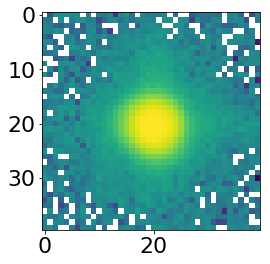

In [44]:
plt.imshow(sci_image,norm=LogNorm())

In [47]:
%prun model(allparameters_proposal)

oversampling of optPSF is: 20.0135710609
oversampling of optPsf_downsampled is: 5
 

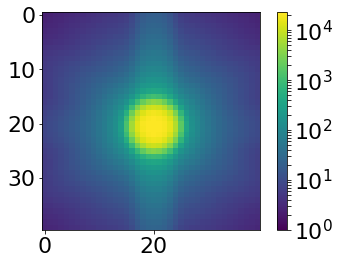

In [46]:
optPsf=np.load(TESTING_FINAL_IMAGES_FOLDER+'optPsf.npy')
optPsf_downsampled=np.load(TESTING_FINAL_IMAGES_FOLDER+'optPsf_downsampled.npy')
optPsf_fiber_convolved=np.load(TESTING_FINAL_IMAGES_FOLDER+'optPsf_fiber_convolved.npy')

optPsf_downsampled_scattered=np.load(TESTING_FINAL_IMAGES_FOLDER+'optPsf_downsampled_scattered.npy')

optPsf_cut_fiber_convolved=np.load(TESTING_FINAL_IMAGES_FOLDER+'optPsf_cut_fiber_convolved.npy')
optPsf_cut_pixel_response_convolved=np.load(TESTING_FINAL_IMAGES_FOLDER+'optPsf_cut_pixel_response_convolved.npy')
optPsf_cut_grating_convolved=np.load(TESTING_FINAL_IMAGES_FOLDER+'optPsf_cut_grating_convolved.npy')
optPsf_cut_fiber_convolved_downsampled=np.load(TESTING_FINAL_IMAGES_FOLDER+'optPsf_cut_fiber_convolved_downsampled.npy')

plt.imshow(optPsf_cut_fiber_convolved_downsampled,norm=LogNorm(),vmax=np.max(optPsf_cut_fiber_convolved_downsampled),vmin=1)
plt.colorbar()

# Preliminary analysis

## some functions I still need -deprecated

In [1624]:
def create_res_data(FFTTest_fiber_and_pixel_convolved_downsampled_40,mask=None,custom_cent=None,size_pixel=None):
    
    if size_pixel is None:
        size_pixel=7.5
    
    image_shape=np.array(FFTTest_fiber_and_pixel_convolved_downsampled_40.shape)
    if custom_cent is None:
        xs0=0
        ys0=0
    else:

        xs0=(find_centroid_of_flux(FFTTest_fiber_and_pixel_convolved_downsampled_40)[0]-int(image_shape[0]/2))*size_pixel
        ys0=(find_centroid_of_flux(FFTTest_fiber_and_pixel_convolved_downsampled_40)[1]-int(image_shape[0]/2))*size_pixel
    pointsx = np.linspace(-(int(image_shape[0]*size_pixel)-size_pixel)/2,(int(image_shape[0]*size_pixel)-size_pixel)/2,num=int(image_shape[0]))
    pointsy = np.linspace(-(int(image_shape[0]*size_pixel)-size_pixel)/2,(int(image_shape[0]*size_pixel)-size_pixel)/2,num=int(image_shape[0]))
    xs, ys = np.meshgrid(pointsx, pointsy)
    r0 = np.sqrt((xs-xs0)** 2 + (ys-ys0)** 2)
    
    if mask is None:
        mask=np.ones((FFTTest_fiber_and_pixel_convolved_downsampled_40.shape[0],FFTTest_fiber_and_pixel_convolved_downsampled_40.shape[1]))
    
    distances=range(int(image_shape[0]/2*size_pixel*1.2))

    res_test_data=[]
    for r in distances:
        pixels_upper_limit=(mask*FFTTest_fiber_and_pixel_convolved_downsampled_40)[r0<(r+size_pixel)]
        pixels_lower_limit=(mask*FFTTest_fiber_and_pixel_convolved_downsampled_40)[r0<(r)]
        
        mask_upper_limit=mask[r0<(r+size_pixel)]
        mask_lower_limit=mask[r0<(r)]
        
        number_of_valid_pixels=np.sum(mask_upper_limit)-np.sum(mask_lower_limit)
        
        if number_of_valid_pixels==0:
            res_test_data.append(0)
        else:                  
            average_flux=(np.sum(pixels_upper_limit)-np.sum(pixels_lower_limit))/number_of_valid_pixels
            res_test_data.append(average_flux)        

    return res_test_data 

def find_centroid_of_flux(image):
    x_center=[]
    y_center=[]

    I_x=[]
    for i in range(image.shape[1]):
        I_x.append([i,np.sum(image[:,i])])

    I_x=np.array(I_x)

    I_y=[]
    for i in range(image.shape[0]):
        I_y.append([i,np.sum(image[i])])

    I_y=np.array(I_y)


    x_center=(np.sum(I_x[:,0]*I_x[:,1])/np.sum(I_x[:,1]))
    y_center=(np.sum(I_y[:,0]*I_y[:,1])/np.sum(I_y[:,1]))

    return(x_center,y_center)

def create_mask_100(FFTTest_fiber_and_pixel_convolved_downsampled_40,semi=None,central_cut_size=None):
    
    if central_cut_size is None:
        central_cut_size=6
            
    central_position=np.array(find_centroid_of_flux(FFTTest_fiber_and_pixel_convolved_downsampled_40))
    central_position_int=np.round(central_position)
    central_position_int_x=int(central_position_int[0])
    central_position_int_y=int(central_position_int[1])
    
    size=FFTTest_fiber_and_pixel_convolved_downsampled_40.shape[0]
    
    center_square=np.zeros((size,size))
    center_square[central_position_int_y-central_cut_size:+central_position_int_y+central_cut_size,central_position_int_x-central_cut_size:central_position_int_x+central_cut_size]=np.ones((int(2*central_cut_size),int(2*central_cut_size)))

    horizontal_cross=np.zeros((size,size))
    horizontal_cross[central_position_int_y-central_cut_size:central_position_int_y+central_cut_size,0:size,]=np.ones((int(2*central_cut_size),size))
    horizontal_cross_full=horizontal_cross
    horizontal_cross=horizontal_cross-center_square

    vertical_cross=np.zeros((size,size))
    if semi is None:
        vertical_cross[0:size,central_position_int_x-central_cut_size:central_position_int_x+central_cut_size]=np.ones((size,int(2*central_cut_size)))
        vertical_cross=vertical_cross-center_square
    if semi=='+':
        vertical_cross[central_position_int_y+central_cut_size:size,central_position_int_x-central_cut_size:central_position_int_x+central_cut_size]=np.ones((size-central_position_int_y-central_cut_size,int(2*central_cut_size)))
    if semi=='-':
        vertical_cross[0:central_position_int_y-central_cut_size,central_position_int_x-central_cut_size:central_position_int_x+central_cut_size]=np.ones((central_position_int_y-central_cut_size,int(2*central_cut_size)))
    vertical_cross_full=vertical_cross


    diagonal_cross=np.zeros((size,size))
    if semi is None:
        diagonal_cross[0:central_position_int_y-int(1.35*central_cut_size),0:central_position_int_x-int(1.35*central_cut_size)]=np.ones((central_position_int_y-int(1.35*central_cut_size),central_position_int_x-int(1.35*central_cut_size)))
        diagonal_cross[(central_position_int_y+int(1.35*central_cut_size)):size,0:(central_position_int_x-int(1.35*central_cut_size))]=np.ones((size-(central_position_int_y+int(1.35*central_cut_size)),(central_position_int_x-int(1.35*central_cut_size))))
        diagonal_cross[0:(central_position_int_y-int(1.35*central_cut_size)),(central_position_int_x+int(1.35*central_cut_size)):size]=np.ones(((central_position_int_y-int(1.35*central_cut_size)),size-(central_position_int_x+int(1.35*central_cut_size))))
        diagonal_cross[(central_position_int_y+int(1.35*central_cut_size)):size,(central_position_int_x+int(1.35*central_cut_size)):size]=np.ones((size-(central_position_int_y+int(1.35*central_cut_size)),size-(central_position_int_x+int(1.35*central_cut_size))))
    if semi=='+':
        diagonal_cross[(central_position_int_y+int(1.35*central_cut_size)):size,0:(central_position_int_x-int(1.35*central_cut_size))]=np.ones((size-(central_position_int_y+8),(central_position_int_x-int(1.35*central_cut_size))))
        diagonal_cross[(central_position_int_y+int(1.35*central_cut_size)):size,(central_position_int_x+int(1.35*central_cut_size)):size]=np.ones((size-(central_position_int_y+8),size-(central_position_int_x+int(1.35*central_cut_size))))
    if semi=='-':
        diagonal_cross[0:central_position_int_y-int(1.35*central_cut_size),0:central_position_int_x-int(1.35*central_cut_size)]=np.ones((central_position_int_y-int(1.35*central_cut_size),central_position_int_x-int(1.35*central_cut_size)))
        diagonal_cross[0:(central_position_int_y-int(1.35*central_cut_size)),(central_position_int_x+int(1.35*central_cut_size)):size]=np.ones(((central_position_int_y-int(1.35*central_cut_size)),size-(central_position_int_x+int(1.35*central_cut_size))))


    total_mask=np.zeros((size,size))
    if semi is None:
        total_mask=np.ones((size,size))
    if semi=='+':
        total_mask[(central_position_int_y):size,0:size]=np.ones((size-(central_position_int_y),size))
    if semi=='-':
        total_mask[:(central_position_int_y),0:size]=np.ones(((central_position_int_y),size))
    if semi=='r':
        total_mask[:(central_position_int_y),0:size]=np.ones(((central_position_int_y),size))  
    if semi=='l':
        total_mask[:(central_position_int_y),0:size]=np.ones(((central_position_int_y),size))   
        
    return [center_square,horizontal_cross,vertical_cross,diagonal_cross,total_mask]


def downsample_manual_function_abs(optPsf_cut_fiber_convolved,npixfinal):
    "input image, and final number of pixels"
    res=[]
    FFTImage_cropped_split=np.array_split(optPsf_cut_fiber_convolved,npixfinal)
    for j in range(len(FFTImage_cropped_split)):
        FFTImage_cropped_split_split=np.array_split(FFTImage_cropped_split[j],npixfinal,axis=1)
        for i in range(len(FFTImage_cropped_split_split)):
            res.append(np.sum(np.abs(FFTImage_cropped_split_split[i])))

    res=np.array(res)
    FFTImage_croppedEvenDownsampled32=res.reshape(npixfinal,npixfinal)
    return FFTImage_croppedEvenDownsampled32

## single object

In [ ]:
distances=range(180)
image_index=55
sci_image_dithered_pp=np.load("/Users/nevencaplar/Documents/PFS/2017-12-15-Rerun/Stamps_long/sci"+str(8600)+str(image_index)+'Stacked_Dithered.npy') 

list_of_masks=create_mask_100(sci_image_dithered_pp)
horizontal_cross=list_of_masks[1]
vertical_cross=list_of_masks[2]
diagonal_cross=list_of_masks[3]
center_square=list_of_masks[0]

res_55=create_res_data(sci_image_dithered_pp,None,1)
res_55_horizontal_cross=create_res_data(sci_image_dithered_pp,horizontal_cross,1)
res_55_vertical_cross=create_res_data(sci_image_dithered_pp,vertical_cross,1)
res_55_diagonal_cross=create_res_data(sci_image_dithered_pp,diagonal_cross,1)
res_55_center_square=create_res_data(sci_image_dithered_pp,center_square,1)

optPsf_dithered=optPsf_cut_fiber_convolved_downsampled
optPsf_dithered_55=create_res_data(optPsf_dithered,None,1)
optPsf_dithered_55_horizontal_cross=create_res_data(optPsf_dithered,horizontal_cross,1)
optPsf_dithered_55_vertical_cross=create_res_data(optPsf_dithered,vertical_cross,1)
optPsf_dithered_55_diagonal_cross=create_res_data(optPsf_dithered,diagonal_cross,1)
optPsf_dithered_55_center_square=create_res_data(optPsf_dithered,center_square,1)

In [ ]:
plt.figure(figsize=(20,12))
#plt.plot(distances,np.log10(res_55),color='black',label='spot 55 ',lw=4)
plt.plot(distances,np.log10(res_55_horizontal_cross),color='orange',label='spot 55, horizontal',lw=4)
plt.plot(distances,np.log10(res_55_vertical_cross),color='red',label='spot 55, vertical',lw=4)
plt.plot(distances,np.log10(res_55_diagonal_cross),color='cyan',label='spot 55, diagonal',lw=4)
plt.plot(distances,np.log10(res_55_center_square),color='blue',label='spot 55, center',lw=4)

#plt.plot(distances,np.log10(zemax_55),color='black',label='zemax 55 ',lw=2,linestyle='--')
plt.plot(distances,np.log10(optPsf_dithered_55_horizontal_cross),color='orange',label='my code 55, horizontal',lw=2,linestyle='--')
plt.plot(distances,np.log10(optPsf_dithered_55_vertical_cross),color='red',label='my code  55, vertical',lw=2,linestyle='--')
plt.plot(distances,np.log10(optPsf_dithered_55_diagonal_cross),color='cyan',label='my code 55, diagonal',lw=2,linestyle='--')
plt.plot(distances,np.log10(optPsf_dithered_55_center_square),color='blue',label='my code  55, center',lw=2,linestyle='--')

plt.xlabel('distance from center in micrometers')
plt.ylabel('log10(counts in a single pixel [7.5x7.5 microns])')
plt.ylim(0.5,4.5)
plt.legend(fontsize=22)
plt.title('normalized')

## getting ready for cluster - testing

In [ ]:
allparameters_proposal=np.array([z4Input,0.09,0.02,-0.1,0.0,0.1,0.02,0.2,
                                 0.65,0.1,0.0,0.0,0.08,0.0,
                                 0.7,2,
                                 -0.2,0.00,0.99,0.0,
                                 9000,20,2.5,10**-1.2,
                                 0.47,1.0])

nT=4
parInit1=create_parInit(allparameters_proposal)
parInit2=create_parInit(allparameters_proposal)
parInit3=create_parInit(allparameters_proposal)
parInit4=create_parInit(allparameters_proposal)
parInitnT=np.array([parInit1,parInit2,parInit3,parInit4])

## making test scripts

In [30]:
for obs in [8564,8567,8570,8573,8600,8606,8609,8612,8615]:
    for single_spot in [55]:
        file = open('/Users/nevencaplar/Documents/PFS/TigerAnalysis/ScriptsForTiger/Test_Perseus'+str(obs)+'Spot'+str(single_spot)+'AugObs_P.sh','w') 

        file.write("#!/bin/bash \n")
        file.write("#SBATCH --nodes=9 # node count \n")
        file.write("#SBATCH --ntasks-per-node=24 \n") 
        file.write("#SBATCH --time 14:59:00 \n")
        file.write("#SBATCH --mail-type=begin  \n")
        file.write("#SBATCH --mail-type=end   \n") 
        file.write("#SBATCH --mail-user=ncaplar@princeton.edu \n")
        
        file.write("\n")
        file.write("#1. Observation (e.g., 8567) \n") 
        file.write("#2. Threads \n") 
        file.write("#3. Steps \n") 
        file.write("\n")

        file.write("mpirun python /home/ncaplar/Code/ZernikeSingle_11_Mix_P_Aug.py "+str(obs)+" "+str(single_spot)+" 10 1\n")
        file.close()

In [33]:
file = open('/Users/nevencaplar/Documents/PFS/TigerAnalysis/ScriptsForTiger/AugustScriptToSubmitScriptsPerseus'+'.sh','w')
file.write("#!/bin/bash \n")
file.write("\n")
for obs in [8600,8606,8615]:
    for single_spot in [55]:
        file.write('sbatch /home/ncaplar/Scripts/Test_Perseus'+str(obs)+'Spot'+str(single_spot)+'AugObs_P.sh \n')

file.close()

## analyzing test run

In [21]:
columns=['z4','z5','z6','z7','z8','z9','z10','z11',
                      'hscFrac','strutFrac','dxFocal','dyFocal','slitFrac','slitFrac_dy',
                      'radiometricEffect','radiometricExponent',
                      'x_ilum','y_ilum','minorAxis','pupilAngle',
                      'grating_lines','scattering_radius','scattering_slope','scattering_amplitude',
                      'pixel_effect','flux']  

method='P'
obs='8615'
date='Aug15'
eps=1
single_number='55'
image_index=55

if obs=='8600':
    sci_image=np.load("/Users/nevencaplar/Documents/PFS/TigerAnalysis/CutsForTigerAug15/sci"+str(obs)+str(image_index)+'Stacked_Cleaned_Dithered.npy')
    var_image=np.load("/Users/nevencaplar/Documents/PFS/TigerAnalysis/CutsForTigerAug15/var"+str(obs)+str(image_index)+'Stacked_Dithered.npy')
else:       
    sci_image=np.load("/Users/nevencaplar/Documents/PFS/TigerAnalysis/CutsForTigerAug15/sci"+str(obs)+str(image_index)+'Stacked_Cleaned.npy')
    var_image=np.load("/Users/nevencaplar/Documents/PFS/TigerAnalysis/CutsForTigerAug15/var"+str(obs)+str(image_index)+'Stacked.npy')



RESULT_FOLDER='/Users/nevencaplar/Documents/PFS/TigerAnalysis/ResultsFromTiger/Aug15/'

# This is for August15 run
####################################
#chain 1
####################################
chain_Emcee1=np.load(RESULT_FOLDER+'chain'+date+'_Single_'+str(method)+'_'+str(obs)+str(single_number)+str(eps)+'Emcee1.npy')
likechain_Emcee1=np.load(RESULT_FOLDER+'likechain'+date+'_Single_'+str(method)+'_'+str(obs)+str(single_number)+str(eps)+'Emcee1.npy')

# get chain number 0, which is has lowest temperature
likechain0_Emcee1=likechain_Emcee1[0]
chain0_Emcee1=chain_Emcee1[0]
# check the shape of the chain (number of walkers, number of steps, number of parameters)
print(chain0_Emcee1.shape)

####################################
#chain 2
####################################
chain_Emcee2=np.load(RESULT_FOLDER+'chain'+date+'_Single_'+str(method)+'_'+str(obs)+str(single_number)+str(eps)+'Emcee2.npy')
likechain_Emcee2=np.load(RESULT_FOLDER+'likechain'+date+'_Single_'+str(method)+'_'+str(obs)+str(single_number)+str(eps)+'Emcee2.npy')

# get chain number 0, which is has lowest temperature
likechain0_Emcee2=likechain_Emcee2[0]
chain0_Emcee2=chain_Emcee2[0]
# check the shape of the chain (number of walkers, number of steps, number of parameters)
chain0_Emcee2.shape

chain_Emcee2=np.load(RESULT_FOLDER+'chain'+date+'_Single_'+str(method)+'_'+str(obs)+str(single_number)+str(eps)+'Emcee2.npy')
likechain_Emcee2=np.load(RESULT_FOLDER+'likechain'+date+'_Single_'+str(method)+'_'+str(obs)+str(single_number)+str(eps)+'Emcee2.npy')

# get chain number 0, which is has lowest temperature
likechain0_Emcee2=likechain_Emcee2[0]
chain0_Emcee2=chain_Emcee2[0]
# check the shape of the chain (number of walkers, number of steps, number of parameters)
print(chain0_Emcee2.shape)

####################################
#chain 3
####################################
chain_Emcee3=np.load(RESULT_FOLDER+'chain'+date+'_Single_'+str(method)+'_'+str(obs)+str(single_number)+str(eps)+'Emcee2.npy')
likechain_Emcee3=np.load(RESULT_FOLDER+'likechain'+date+'_Single_'+str(method)+'_'+str(obs)+str(single_number)+str(eps)+'Emcee2.npy')

# get chain number 0, which is has lowest temperature
likechain0_Emcee3=likechain_Emcee3[0]
chain0_Emcee3=chain_Emcee3[0]
# check the shape of the chain (number of walkers, number of steps, number of parameters)
chain0_Emcee3.shape

chain_Emcee3=np.load(RESULT_FOLDER+'chain'+date+'_Single_'+str(method)+'_'+str(obs)+str(single_number)+str(eps)+'Emcee3.npy')
likechain_Emcee3=np.load(RESULT_FOLDER+'likechain'+date+'_Single_'+str(method)+'_'+str(obs)+str(single_number)+str(eps)+'Emcee3.npy')

# get chain number 0, which is has lowest temperature
likechain0_Emcee3=likechain_Emcee3[0]
chain0_Emcee3=chain_Emcee3[0]
# check the shape of the chain (number of walkers, number of steps, number of parameters)
print(chain0_Emcee3.shape)


(260, 10, 26)
(260, 10, 26)
(260, 20, 26)


In [22]:
# minimal value of absolute likelihood
np.min(np.abs(likechain0_Emcee3))

13722.306054419885

In [24]:
# see the best chain, in numpy and pandas form
minchain=chain0_Emcee3[np.abs(likechain0_Emcee3)==np.min(np.abs(likechain0_Emcee3))][0]
minchain31=minchain
print(minchain)
dfz22 = pd.DataFrame(np.array([np.array([minchain])[0][0:8]]),columns=columns[0:8])
print(dfz22)
dfglobal = pd.DataFrame(np.array([np.array([minchain])[0][8:]]),columns=columns[8:])
print(dfglobal)

[   -16.50606443     -0.0679086       0.40323188     -0.11156629
     -0.31938677     -0.08015925     -0.19248356     -0.27833116
      0.71320999      0.09732131     -0.0149267       0.02958832
      0.05338593      0.07345508      0.61837389      2.39938781
      0.06075449      0.02716831      0.99111871      0.27042571
  45594.63689485     55.38796807      2.28200189      0.04965618
      0.63224565      1.03792212]
          z4        z5        z6        z7        z8        z9       z10  \
0 -16.506064 -0.067909  0.403232 -0.111566 -0.319387 -0.080159 -0.192484   

        z11  
0 -0.278331  
   hscFrac  strutFrac   dxFocal   dyFocal  slitFrac  slitFrac_dy  \
0  0.71321   0.097321 -0.014927  0.029588  0.053386     0.073455   

   radiometricEffect  radiometricExponent    x_ilum    y_ilum  minorAxis  \
0           0.618374             2.399388  0.060754  0.027168   0.991119   

   pupilAngle  grating_lines  scattering_radius  scattering_slope  \
0    0.270426   45594.636895        

In [25]:
like_min=[]
for i in range(likechain0_Emcee1.shape[1]):
    like_min.append(np.min(np.abs(likechain0_Emcee1[:,i])))

for i in range(likechain0_Emcee2.shape[1]):
    like_min.append(np.min(np.abs(likechain0_Emcee2[:,i])))    

for i in range(likechain0_Emcee3.shape[1]):
    like_min.append(np.min(np.abs(likechain0_Emcee3[:,i]))  )  
    
print('minimal likelihood is: '+str(np.min(like_min)))   
chi2=(np.array(like_min)*(2)-np.log(2*np.pi*np.sum(var_image)))/(sci_image.shape[0])**2
print('minimal chi2 reduced is: '+str(np.min(chi2)))

minimal likelihood is: 13722.3060544
minimal chi2 reduced is: 30.4768541592


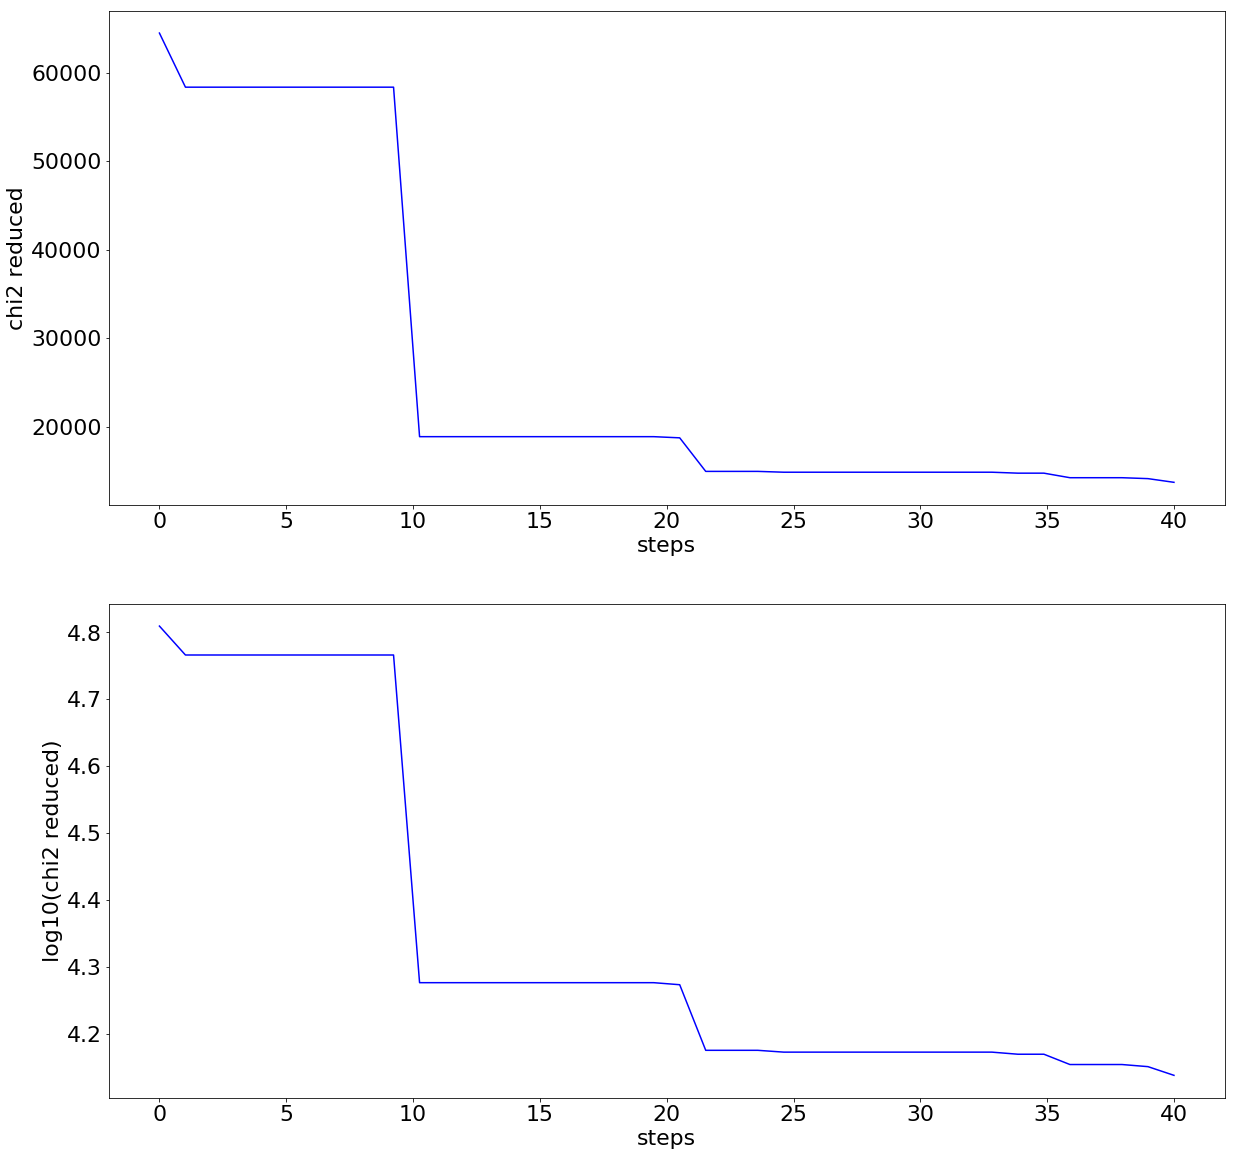

In [26]:
plt.figure(figsize=(20,20))
plt.subplot(211)
plt.plot(np.linspace(0,len(like_min),len(like_min)),like_min,'blue',ls='-')
plt.ylabel('chi2 reduced')
plt.xlabel('steps')
plt.subplot(212)
plt.plot(np.linspace(0,len(like_min),len(like_min)),np.log10(like_min),'blue',ls='-')
plt.ylabel('log10(chi2 reduced)')
plt.xlabel('steps')

In [27]:
zparameters=minchain[0:8]
globalparameters=minchain[8:]


if obs=='8600':
    model = LN_PFS_single(sci_image,var_image,dithering=2)
else:
    model = LN_PFS_single(sci_image,var_image,dithering=1)   

x=LN_PFS_single(sci_image,var_image).create_x(zparameters,globalparameters)

In [28]:
model(x)

oversampling of optPSF is: 40.0271421218
oversampling of optPsf_downsampled is: 10


-13722.306054419932

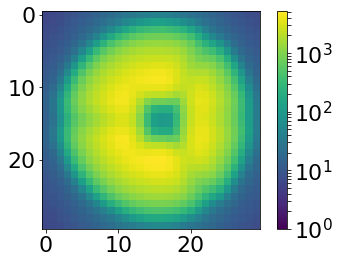

In [29]:
optPsf=np.load(TESTING_FINAL_IMAGES_FOLDER+'optPsf.npy')
optPsf_downsampled=np.load(TESTING_FINAL_IMAGES_FOLDER+'optPsf_downsampled.npy')
optPsf_fiber_convolved=np.load(TESTING_FINAL_IMAGES_FOLDER+'optPsf_fiber_convolved.npy')

optPsf_downsampled_scattered=np.load(TESTING_FINAL_IMAGES_FOLDER+'optPsf_downsampled_scattered.npy')

optPsf_cut_fiber_convolved=np.load(TESTING_FINAL_IMAGES_FOLDER+'optPsf_cut_fiber_convolved.npy')
optPsf_cut_pixel_response_convolved=np.load(TESTING_FINAL_IMAGES_FOLDER+'optPsf_cut_pixel_response_convolved.npy')
optPsf_cut_grating_convolved=np.load(TESTING_FINAL_IMAGES_FOLDER+'optPsf_cut_grating_convolved.npy')
optPsf_cut_fiber_convolved_downsampled=np.load(TESTING_FINAL_IMAGES_FOLDER+'optPsf_cut_fiber_convolved_downsampled.npy')

plt.imshow(optPsf_cut_fiber_convolved_downsampled,norm=LogNorm(),vmax=np.max(optPsf_cut_fiber_convolved_downsampled),vmin=1)
plt.colorbar()

chi**2 reduced is: 30.4768541876
Abs of residual divided by total flux is: 0.11189335973
Abs of residual divided by largest value of a flux in the image is: 0.221215977412


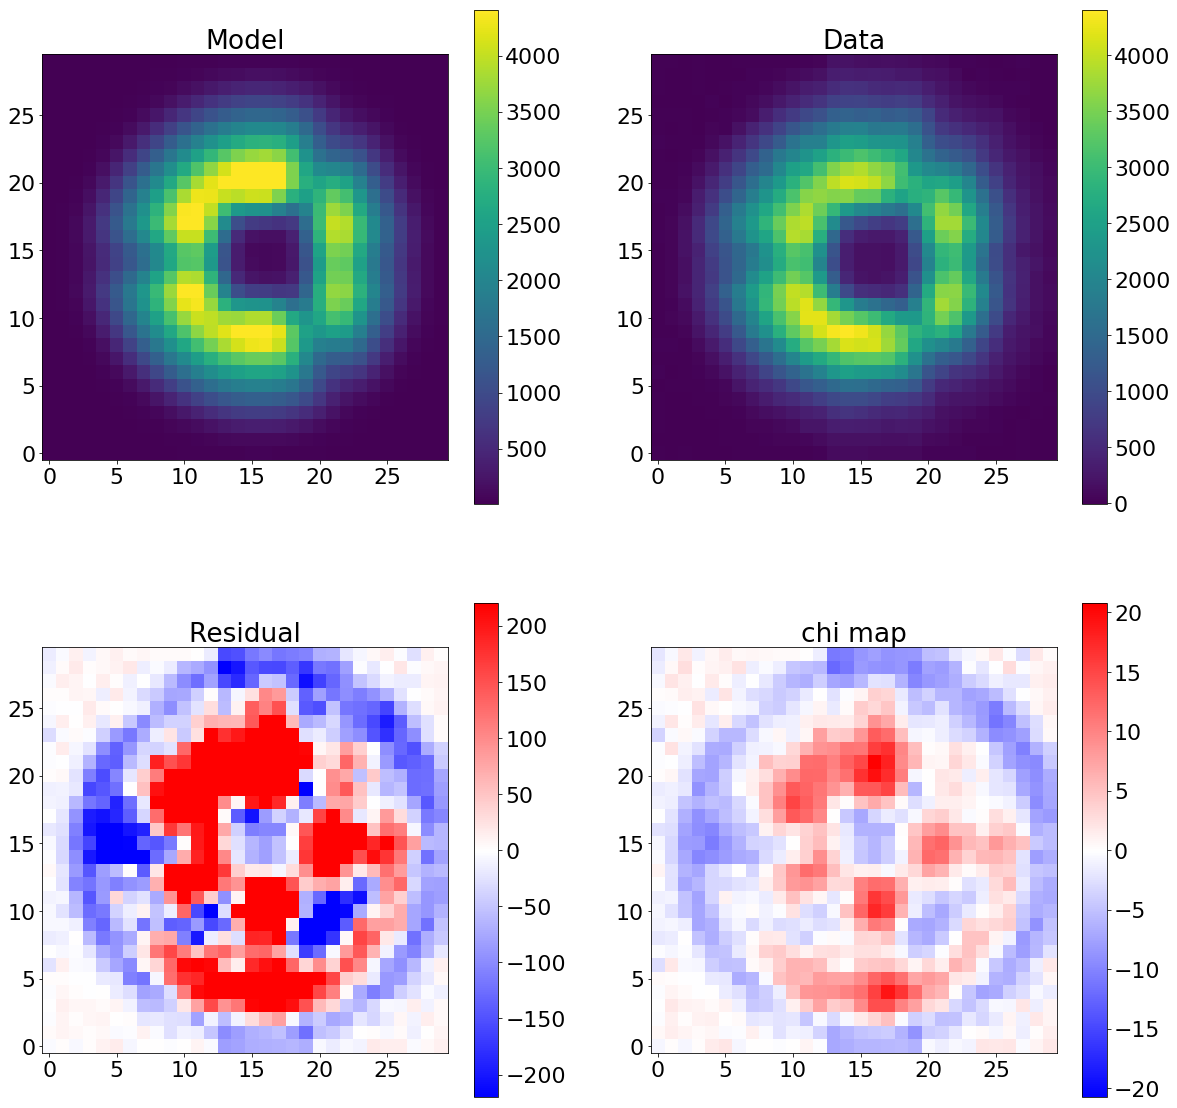

In [30]:
res_iapetus=optPsf_cut_fiber_convolved_downsampled
inputimage=sci_image
var_inputimage=var_image


plt.figure(figsize=(20,20))
plt.subplot(221)
plt.imshow(res_iapetus,origin='lower',vmax=np.max(np.abs(inputimage)))
plt.colorbar()
plt.title('Model')
plt.grid(False)
plt.subplot(222)
plt.imshow(inputimage,origin='lower',vmax=np.max(np.abs(inputimage)))
plt.colorbar()
plt.title('Data')
plt.grid(False)
plt.subplot(223)
plt.imshow(res_iapetus-inputimage,origin='lower',cmap='bwr',vmin=-np.max(np.abs(inputimage))/20,vmax=np.max(np.abs(inputimage))/20)
plt.colorbar()
plt.title('Residual')
plt.grid(False)
plt.subplot(224)
plt.imshow((res_iapetus-inputimage)/np.sqrt(var_inputimage),origin='lower',cmap='bwr',vmax=np.max(np.abs((res_iapetus-inputimage)/np.sqrt(var_inputimage))),vmin=-np.max(np.abs((res_iapetus-inputimage)/np.sqrt(var_inputimage))))
plt.colorbar()
plt.title('chi map')
print('chi**2 reduced is: '+str(np.sum((res_iapetus-inputimage)**2/((var_inputimage.shape[0]*var_inputimage.shape[1])*var_inputimage))))
print('Abs of residual divided by total flux is: '+str(np.sum(np.abs((res_iapetus-inputimage)))/np.sum((res_iapetus))))
print('Abs of residual divided by largest value of a flux in the image is: '+str(np.max(np.abs((res_iapetus-inputimage)/np.max(res_iapetus)))))

# Analysis 

## creating scripts - Perseus (Aug 21)

In [1922]:
for single_spot in [55]:
    file = open('/Users/nevencaplar/Documents/PFS/TigerAnalysis/ScriptsForTiger/Perseus'+str(1)+'Spot'+str(single_spot)+'AugObs_P.sh','w') 
    
    file.write("#!/bin/bash \n")
    file.write("#SBATCH --nodes=9 # node count \n")
    file.write("#SBATCH --ntasks-per-node=24 \n") 
    file.write("#SBATCH --time 14:59:00 \n")
    file.write("#SBATCH --mail-type=begin  \n")
    file.write("#SBATCH --mail-type=end   \n") 
    file.write("#SBATCH --mail-user=ncaplar@princeton.edu \n")

    file.write("\n")
    file.write("#1. Observation (e.g., 8567) \n") 
    file.write("#2. Threads \n") 
    file.write("#3. Steps \n") 
    file.write("\n")

    for obs in [8564,8615]:

        file.write("mpirun python /home/ncaplar/Code/ZernikeSingle_11_Mix_P_Aug.py "+str(obs)+" "+str(single_spot)+" 150 1\n")
    file.close()
    
for single_spot in [55]:
    file = open('/Users/nevencaplar/Documents/PFS/TigerAnalysis/ScriptsForTiger/Perseus'+str(2)+'Spot'+str(single_spot)+'AugObs_P.sh','w') 
    
    file.write("#!/bin/bash \n")
    file.write("#SBATCH --nodes=9 # node count \n")
    file.write("#SBATCH --ntasks-per-node=24 \n") 
    file.write("#SBATCH --time 14:59:00 \n")
    file.write("#SBATCH --mail-type=begin  \n")
    file.write("#SBATCH --mail-type=end   \n") 
    file.write("#SBATCH --mail-user=ncaplar@princeton.edu \n")

    file.write("\n")
    file.write("#1. Observation (e.g., 8567) \n") 
    file.write("#2. Threads \n") 
    file.write("#3. Steps \n") 
    file.write("\n")

    for obs in [8600,8573]:

        file.write("mpirun python /home/ncaplar/Code/ZernikeSingle_11_Mix_P_Aug.py "+str(obs)+" "+str(single_spot)+" 150 1\n")
    file.close()
    
for single_spot in [55]:
    file = open('/Users/nevencaplar/Documents/PFS/TigerAnalysis/ScriptsForTiger/Perseus'+str(3)+'Spot'+str(single_spot)+'AugObs_P.sh','w') 
    
    file.write("#!/bin/bash \n")
    file.write("#SBATCH --nodes=9 # node count \n")
    file.write("#SBATCH --ntasks-per-node=24 \n") 
    file.write("#SBATCH --time 14:59:00 \n")
    file.write("#SBATCH --mail-type=begin  \n")
    file.write("#SBATCH --mail-type=end   \n") 
    file.write("#SBATCH --mail-user=ncaplar@princeton.edu \n")

    file.write("\n")
    file.write("#1. Observation (e.g., 8567) \n") 
    file.write("#2. Threads \n") 
    file.write("#3. Steps \n") 
    file.write("\n")

    for obs in [8570,8609]:

        file.write("mpirun python /home/ncaplar/Code/ZernikeSingle_11_Mix_P_Aug.py "+str(obs)+" "+str(single_spot)+" 150 1\n")
    file.close()    
    
for single_spot in [55]:
    file = open('/Users/nevencaplar/Documents/PFS/TigerAnalysis/ScriptsForTiger/Perseus'+str(4)+'Spot'+str(single_spot)+'AugObs_P.sh','w') 
    
    file.write("#!/bin/bash \n")
    file.write("#SBATCH --nodes=9 # node count \n")
    file.write("#SBATCH --ntasks-per-node=24 \n") 
    file.write("#SBATCH --time 14:59:00 \n")
    file.write("#SBATCH --mail-type=begin  \n")
    file.write("#SBATCH --mail-type=end   \n") 
    file.write("#SBATCH --mail-user=ncaplar@princeton.edu \n")

    file.write("\n")
    file.write("#1. Observation (e.g., 8567) \n") 
    file.write("#2. Threads \n") 
    file.write("#3. Steps \n") 
    file.write("\n")

    for obs in [8612,8606]:

        file.write("mpirun python /home/ncaplar/Code/ZernikeSingle_11_Mix_P_Aug.py "+str(obs)+" "+str(single_spot)+" 150 1\n")
    file.close()  
    
for single_spot in [55]:
    file = open('/Users/nevencaplar/Documents/PFS/TigerAnalysis/ScriptsForTiger/Perseus'+str(5)+'Spot'+str(single_spot)+'AugObs_P.sh','w') 
    
    file.write("#!/bin/bash \n")
    file.write("#SBATCH --nodes=9 # node count \n")
    file.write("#SBATCH --ntasks-per-node=24 \n") 
    file.write("#SBATCH --time 14:59:00 \n")
    file.write("#SBATCH --mail-type=begin  \n")
    file.write("#SBATCH --mail-type=end   \n") 
    file.write("#SBATCH --mail-user=ncaplar@princeton.edu \n")

    file.write("\n")
    file.write("#1. Observation (e.g., 8567) \n") 
    file.write("#2. Threads \n") 
    file.write("#3. Steps \n") 
    file.write("\n")

    for obs in [8603,8567]:

        file.write("mpirun python /home/ncaplar/Code/ZernikeSingle_11_Mix_P_Aug.py "+str(obs)+" "+str(single_spot)+" 150 1\n")
    file.close()      

In [1923]:
file = open('/Users/nevencaplar/Documents/PFS/TigerAnalysis/ScriptsForTiger/AugustScriptToSubmitScriptsPerseus'+'.sh','w')
file.write("#!/bin/bash \n")
file.write("\n")
for obs in [1,2,3,4,5]:
    for single_spot in [55]:
        file.write('sbatch /home/ncaplar/Scripts/Perseus'+str(obs)+'Spot'+str(single_spot)+'AugObs_P.sh \n')

file.close()

## creating scripts - Combination of TigerCPU and Perseus (Aug 22)

In [2169]:
for single_spot in [55]:
    file = open('/Users/nevencaplar/Documents/PFS/TigerAnalysis/ScriptsForTiger/Perseus'+str(1)+'Spot'+str(single_spot)+'AugObs_P.sh','w') 
    
    file.write("#!/bin/bash \n")
    file.write("#SBATCH --nodes=9 # node count \n")
    file.write("#SBATCH --ntasks-per-node=28 \n") 
    file.write("#SBATCH --time 14:59:00 \n")
    file.write("#SBATCH --mail-type=begin  \n")
    file.write("#SBATCH --mail-type=end   \n") 
    file.write("#SBATCH --mail-user=ncaplar@princeton.edu \n")

    file.write("\n")
    file.write("#1. Observation (e.g., 8567) \n") 
    file.write("#2. Threads \n") 
    file.write("#3. Steps \n") 
    file.write("\n")

    for obs in [8564,8615]:

        file.write("mpirun python /home/ncaplar/Code/ZernikeSingle_11_Mix_P_Aug.py "+str(obs)+" "+str(single_spot)+" 150 1\n")
    file.close()
    
for single_spot in [55]:
    file = open('/Users/nevencaplar/Documents/PFS/TigerAnalysis/ScriptsForTiger/Perseus'+str(2)+'Spot'+str(single_spot)+'AugObs_P.sh','w') 
    
    file.write("#!/bin/bash \n")
    file.write("#SBATCH --nodes=9 # node count \n")
    file.write("#SBATCH --ntasks-per-node=28 \n") 
    file.write("#SBATCH --time 14:59:00 \n")
    file.write("#SBATCH --mail-type=begin  \n")
    file.write("#SBATCH --mail-type=end   \n") 
    file.write("#SBATCH --mail-user=ncaplar@princeton.edu \n")

    file.write("\n")
    file.write("#1. Observation (e.g., 8567) \n") 
    file.write("#2. Threads \n") 
    file.write("#3. Steps \n") 
    file.write("\n")

    for obs in [8600,8573]:

        file.write("mpirun python /home/ncaplar/Code/ZernikeSingle_11_Mix_P_Aug.py "+str(obs)+" "+str(single_spot)+" 150 1\n")
    file.close()


for single_spot in [55]:
    file = open('/Users/nevencaplar/Documents/PFS/TigerAnalysis/ScriptsForTiger/Perseus'+str(3)+'Spot'+str(single_spot)+'AugObs_P.sh','w') 
    
    file.write("#!/bin/bash \n")
    file.write("#SBATCH --nodes=9 # node count \n")
    file.write("#SBATCH --ntasks-per-node=24 \n") 
    file.write("#SBATCH --time 14:59:00 \n")
    file.write("#SBATCH --mail-type=begin  \n")
    file.write("#SBATCH --mail-type=end   \n") 
    file.write("#SBATCH --mail-user=ncaplar@princeton.edu \n")

    file.write("\n")
    file.write("#1. Observation (e.g., 8567) \n") 
    file.write("#2. Threads \n") 
    file.write("#3. Steps \n") 
    file.write("\n")

    for obs in [8570,8609]:

        file.write("mpirun python /home/ncaplar/Code/ZernikeSingle_11_Mix_P_Aug.py "+str(obs)+" "+str(single_spot)+" 150 1\n")
    file.close()    
    
for single_spot in [55]:
    file = open('/Users/nevencaplar/Documents/PFS/TigerAnalysis/ScriptsForTiger/Perseus'+str(4)+'Spot'+str(single_spot)+'AugObs_P.sh','w') 
    
    file.write("#!/bin/bash \n")
    file.write("#SBATCH --nodes=9 # node count \n")
    file.write("#SBATCH --ntasks-per-node=24 \n") 
    file.write("#SBATCH --time 14:59:00 \n")
    file.write("#SBATCH --mail-type=begin  \n")
    file.write("#SBATCH --mail-type=end   \n") 
    file.write("#SBATCH --mail-user=ncaplar@princeton.edu \n")

    file.write("\n")
    file.write("#1. Observation (e.g., 8567) \n") 
    file.write("#2. Threads \n") 
    file.write("#3. Steps \n") 
    file.write("\n")

    for obs in [8612,8606]:

        file.write("mpirun python /home/ncaplar/Code/ZernikeSingle_11_Mix_P_Aug.py "+str(obs)+" "+str(single_spot)+" 150 1\n")
    file.close()  
    
for single_spot in [55]:
    file = open('/Users/nevencaplar/Documents/PFS/TigerAnalysis/ScriptsForTiger/Perseus'+str(5)+'Spot'+str(single_spot)+'AugObs_P.sh','w') 
    
    file.write("#!/bin/bash \n")
    file.write("#SBATCH --nodes=9 # node count \n")
    file.write("#SBATCH --ntasks-per-node=24 \n") 
    file.write("#SBATCH --time 14:59:00 \n")
    file.write("#SBATCH --mail-type=begin  \n")
    file.write("#SBATCH --mail-type=end   \n") 
    file.write("#SBATCH --mail-user=ncaplar@princeton.edu \n")

    file.write("\n")
    file.write("#1. Observation (e.g., 8567) \n") 
    file.write("#2. Threads \n") 
    file.write("#3. Steps \n") 
    file.write("\n")

    for obs in [8603,8567]:

        file.write("mpirun python /home/ncaplar/Code/ZernikeSingle_11_Mix_P_Aug.py "+str(obs)+" "+str(single_spot)+" 150 1\n")
    file.close() 

In [2170]:
file = open('/Users/nevencaplar/Documents/PFS/TigerAnalysis/ScriptsForTiger/AugustScriptToSubmitScriptsPerseus'+'.sh','w')
file.write("#!/bin/bash \n")
file.write("\n")
for obs in [1,2,3,4,5]:
    for single_spot in [55]:
        file.write('sbatch /home/ncaplar/Scripts/Perseus'+str(obs)+'Spot'+str(single_spot)+'AugObs_P.sh \n')

file.close()

In [2179]:
file = open('/Users/nevencaplar/Documents/PFS/TigerAnalysis/ScriptsForTiger/TigerCPU'+str(1)+'AugObs_P.sh','w') 

file.write("#!/bin/bash \n")
file.write("#SBATCH --nodes=6 # node count \n")
file.write("#SBATCH --ntasks-per-node=40 \n") 
file.write("#SBATCH --time 14:59:00 \n")
file.write("#SBATCH --mail-type=begin  \n")
file.write("#SBATCH --mail-type=end   \n") 
file.write("#SBATCH --mail-user=ncaplar@princeton.edu \n")

file.write("\n")
file.write("#1. Observation (e.g., 8567) \n") 
file.write("#2. Threads \n") 
file.write("#3. Steps \n") 
file.write("\n")

for single_spot in [54,53]:
    file.write("mpirun python /home/ncaplar/Code/ZernikeSingle_11_Mix_P_Aug.py "+str(8600)+" "+str(single_spot)+" 150 1\n")
file.close()  
    
file = open('/Users/nevencaplar/Documents/PFS/TigerAnalysis/ScriptsForTiger/TigerCPU'+str(2)+'AugObs_P.sh','w') 

file.write("#!/bin/bash \n")
file.write("#SBATCH --nodes=6 # node count \n")
file.write("#SBATCH --ntasks-per-node=40 \n") 
file.write("#SBATCH --time 14:59:00 \n")
file.write("#SBATCH --mail-type=begin  \n")
file.write("#SBATCH --mail-type=end   \n") 
file.write("#SBATCH --mail-user=ncaplar@princeton.edu \n")

file.write("\n")
file.write("#1. Observation (e.g., 8567) \n") 
file.write("#2. Threads \n") 
file.write("#3. Steps \n") 
file.write("\n")

for single_spot in [44,43]:
    file.write("mpirun python /home/ncaplar/Code/ZernikeSingle_11_Mix_P_Aug.py "+str(8600)+" "+str(single_spot)+" 150 1\n")
file.close()  
    

file = open('/Users/nevencaplar/Documents/PFS/TigerAnalysis/ScriptsForTiger/TigerCPU'+str(3)+'AugObs_P.sh','w') 

file.write("#!/bin/bash \n")
file.write("#SBATCH --nodes=6 # node count \n")
file.write("#SBATCH --ntasks-per-node=40 \n") 
file.write("#SBATCH --time 14:59:00 \n")
file.write("#SBATCH --mail-type=begin  \n")
file.write("#SBATCH --mail-type=end   \n") 
file.write("#SBATCH --mail-user=ncaplar@princeton.edu \n")

file.write("\n")
file.write("#1. Observation (e.g., 8567) \n") 
file.write("#2. Threads \n") 
file.write("#3. Steps \n") 
file.write("\n")

for single_spot in [45,99]:
    file.write("mpirun python /home/ncaplar/Code/ZernikeSingle_11_Mix_P_Aug.py "+str(8600)+" "+str(single_spot)+" 150 1\n")
file.close()    

In [2180]:
file = open('/Users/nevencaplar/Documents/PFS/TigerAnalysis/ScriptsForTiger/AugustScriptToSubmitScriptsTigerCPU'+'.sh','w')
file.write("#!/bin/bash \n")
file.write("\n")
for obs in [1,2,3]:
        file.write('sbatch /home/ncaplar/Scripts/TigerCPU'+str(obs)+'AugObs_P.sh \n')

file.close()

## Analysis 

In [2010]:
results_of_fit_single=pd.DataFrame(np.zeros((10,len(columns))).reshape(-1,len(columns)),index=['-2','-1.5','-1','-0.5','0','0','0.5','1','1.5','2'],columns=columns)
err_results_of_fit_single=pd.DataFrame(np.zeros((10,len(columns))).reshape(-1,len(columns)),index=['-2','-1.5','-1','-0.5','0','0','0.5','1','1.5','2'],columns=columns)

In [2011]:
results_of_fit_single

,z4,z5,z6,z7,z8,z9,z10,z11,hscFrac,strutFrac,...,y_ilum,minorAxis,pupilAngle,grating_lines,scattering_radius,scattering_slope,scattering_amplitude,pixel_effect,fiber_r,flux
-2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
-1.5,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
-1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
-0.5,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
0.5,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1.5,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [2014]:
# arrange all results in one pandas 
date='Aug21'

RESULT_FOLDER='/Users/nevencaplar/Documents/PFS/TigerAnalysis/ResultsFromTiger/'+str(date)+'/'

single_defocus_list=[8564,8567,8570,8573,8600,8603,8606,8609,8612,8615]

single_number=55
image_index=single_number
method='P'
eps=1

for single_defocus in tqdm(range(0,len(single_defocus_list))):
    try:
        obs=single_defocus_list[single_defocus]
        try:
            chain=np.load(RESULT_FOLDER+'chain'+str(date)+'_Single_'+str(method)+'_'+str(obs)+str(single_number)+str(eps)+'Emcee3.npy')
            likechain=np.load(RESULT_FOLDER+'likechain'+str(date)+'_Single_'+str(method)+'_'+str(obs)+str(single_number)+str(eps)+'Emcee3.npy')
        except:    
            chain=np.load(RESULT_FOLDER+'chain'+str(date)+'_Single_'+str(method)+'_'+str(obs)+str(single_number)+str(eps)+'Emcee2.npy')
            likechain=np.load(RESULT_FOLDER+'likechain'+str(date)+'_Single_'+str(method)+'_'+str(obs)+str(single_number)+str(eps)+'Emcee2.npy')
            
        
        if obs==8600:
            sci_image=np.load("/Users/nevencaplar/Documents/PFS/TigerAnalysis/CutsForTigerAug15/sci"+str(obs)+str(image_index)+'Stacked_Cleaned_Dithered.npy')
            var_image=np.load("/Users/nevencaplar/Documents/PFS/TigerAnalysis/CutsForTigerAug15/var"+str(obs)+str(image_index)+'Stacked_Dithered.npy')
        else:       
            sci_image=np.load("/Users/nevencaplar/Documents/PFS/TigerAnalysis/CutsForTigerAug15/sci"+str(obs)+str(image_index)+'Stacked_Cleaned.npy')
            var_image=np.load("/Users/nevencaplar/Documents/PFS/TigerAnalysis/CutsForTigerAug15/var"+str(obs)+str(image_index)+'Stacked.npy')


        likechain0=likechain[0]

        chain0=chain[0]
        minchain=chain0[np.abs(likechain0)==np.min(np.abs(likechain0))][0]
        chi2reduced=2*np.min(np.abs(likechain0))/(sci_image.shape[0])**2


        minchain_err=[]
        for i in range(len(columns)):
            minchain_err=np.append(minchain_err,np.sqrt(chi2reduced)*np.std(chain0[:,:,i].flatten()))
    
        minchain_err=np.array(minchain_err)
        results_of_fit_single.iloc[single_defocus]=minchain
        err_results_of_fit_single.iloc[single_defocus]=minchain_err
        
    except:
        ValueError

100%|██████████| 10/10 [00:00<00:00, 40.96it/s]


In [2015]:
results_of_fit_single

,z4,z5,z6,z7,z8,z9,z10,z11,hscFrac,strutFrac,...,y_ilum,minorAxis,pupilAngle,grating_lines,scattering_radius,scattering_slope,scattering_amplitude,pixel_effect,fiber_r,flux
-2,14.922426,-0.027966,0.011523,0.319236,0.112439,-0.123413,-0.238195,-0.305581,0.742528,0.080457,...,0.047273,0.913092,0.116296,65954.184863,64.039045,2.366261,0.048321,0.718422,1.626620,1.002208
-1.5,10.991268,-0.373921,-0.414703,0.297651,-0.202259,-0.078586,-0.217731,-0.330433,0.719733,0.077734,...,0.058616,0.960175,-0.323117,44380.190811,32.906695,1.287665,0.033354,0.444595,1.808403,0.976282
-1,7.662552,-0.302381,-0.396635,0.448681,-0.009667,-0.075650,-0.212032,-0.751324,0.703864,0.055557,...,0.091503,0.981405,-0.785170,65443.773324,23.335552,3.011750,0.073222,0.478325,1.881739,0.951172
-0.5,3.496736,-0.133496,-0.262239,0.262258,0.066871,-0.135972,-0.105285,-0.293196,0.842614,0.105980,...,0.115155,0.910941,-0.398432,59967.283710,47.161432,1.936794,0.037712,0.442975,1.889451,0.967138
0,-0.036784,0.200587,-0.296188,-0.169006,-0.527686,-0.170074,-0.081628,-0.471523,0.683345,0.138156,...,0.032574,0.962371,-0.067230,63974.852289,52.300371,2.591468,0.053919,0.486108,1.904993,0.998236
0,0.429945,-0.619990,-0.606670,-0.452568,0.344936,0.068199,0.894132,-0.597117,0.962945,0.154816,...,0.010965,0.928589,0.664431,34560.069294,5.787804,3.225749,0.035648,0.504835,1.892724,0.979560
0.5,-4.713537,-0.534469,0.171329,0.329861,-0.198039,-0.241227,-0.413782,-0.301093,0.600897,0.143132,...,0.152443,0.895143,1.413643,107263.968845,23.885027,2.876908,0.100363,0.892354,1.710487,0.975609
1,-9.219565,-0.174493,-0.382333,0.367857,-0.138328,-0.225984,-0.394237,-0.480411,0.691821,0.077478,...,-0.023003,0.957717,0.034326,56362.662938,57.313111,2.782836,0.073098,0.457605,1.929181,0.971885
1.5,-12.395159,-0.335239,-0.009291,0.166177,-0.335659,-0.145709,-0.309065,-0.400466,0.728622,0.088594,...,0.063260,0.997848,-0.185145,34909.333860,56.608790,2.473756,0.087674,0.551272,1.898480,0.999142
2,-16.985779,-0.020063,0.211892,0.309036,-0.557683,-0.275866,-0.376825,-0.278041,0.676928,0.087456,...,-0.035390,0.998755,-0.299390,65081.075148,71.254926,3.215773,0.130731,0.679724,1.982914,0.952859


In [2016]:
results_of_fit_single_full=np.copy(results_of_fit_single)
err_results_of_fit_single_full=np.copy(err_results_of_fit_single)

results_of_fit_single=results_of_fit_single[np.abs(results_of_fit_single['z4'])>0]
err_results_of_fit_single=err_results_of_fit_single[np.abs(err_results_of_fit_single['z4'])>0]

In [2017]:
results_of_fit_single

,z4,z5,z6,z7,z8,z9,z10,z11,hscFrac,strutFrac,...,y_ilum,minorAxis,pupilAngle,grating_lines,scattering_radius,scattering_slope,scattering_amplitude,pixel_effect,fiber_r,flux
-2,14.922426,-0.027966,0.011523,0.319236,0.112439,-0.123413,-0.238195,-0.305581,0.742528,0.080457,...,0.047273,0.913092,0.116296,65954.184863,64.039045,2.366261,0.048321,0.718422,1.626620,1.002208
-1.5,10.991268,-0.373921,-0.414703,0.297651,-0.202259,-0.078586,-0.217731,-0.330433,0.719733,0.077734,...,0.058616,0.960175,-0.323117,44380.190811,32.906695,1.287665,0.033354,0.444595,1.808403,0.976282
-1,7.662552,-0.302381,-0.396635,0.448681,-0.009667,-0.075650,-0.212032,-0.751324,0.703864,0.055557,...,0.091503,0.981405,-0.785170,65443.773324,23.335552,3.011750,0.073222,0.478325,1.881739,0.951172
-0.5,3.496736,-0.133496,-0.262239,0.262258,0.066871,-0.135972,-0.105285,-0.293196,0.842614,0.105980,...,0.115155,0.910941,-0.398432,59967.283710,47.161432,1.936794,0.037712,0.442975,1.889451,0.967138
0,-0.036784,0.200587,-0.296188,-0.169006,-0.527686,-0.170074,-0.081628,-0.471523,0.683345,0.138156,...,0.032574,0.962371,-0.067230,63974.852289,52.300371,2.591468,0.053919,0.486108,1.904993,0.998236
0,0.429945,-0.619990,-0.606670,-0.452568,0.344936,0.068199,0.894132,-0.597117,0.962945,0.154816,...,0.010965,0.928589,0.664431,34560.069294,5.787804,3.225749,0.035648,0.504835,1.892724,0.979560
0.5,-4.713537,-0.534469,0.171329,0.329861,-0.198039,-0.241227,-0.413782,-0.301093,0.600897,0.143132,...,0.152443,0.895143,1.413643,107263.968845,23.885027,2.876908,0.100363,0.892354,1.710487,0.975609
1,-9.219565,-0.174493,-0.382333,0.367857,-0.138328,-0.225984,-0.394237,-0.480411,0.691821,0.077478,...,-0.023003,0.957717,0.034326,56362.662938,57.313111,2.782836,0.073098,0.457605,1.929181,0.971885
1.5,-12.395159,-0.335239,-0.009291,0.166177,-0.335659,-0.145709,-0.309065,-0.400466,0.728622,0.088594,...,0.063260,0.997848,-0.185145,34909.333860,56.608790,2.473756,0.087674,0.551272,1.898480,0.999142
2,-16.985779,-0.020063,0.211892,0.309036,-0.557683,-0.275866,-0.376825,-0.278041,0.676928,0.087456,...,-0.035390,0.998755,-0.299390,65081.075148,71.254926,3.215773,0.130731,0.679724,1.982914,0.952859


In [2018]:
from scipy.optimize import curve_fit

def lin_fit_1D(x, a, b):
    return a * x + b

def lin_fit_1DConstant(x, b):
    return  b

index_arr=np.array(err_results_of_fit_single.index.values)
index_arr=np.array(map(float,index_arr))

q='z8'
z4_arr=np.array(results_of_fit_single[q])
z4_arr_err=np.array(err_results_of_fit_single[q])
popt, pcov = curve_fit(lin_fit_1D, index_arr, z4_arr, sigma=z4_arr_err)

In [2019]:
fit_res=[]
for i in np.linspace(-2.5,2.5,11):
    fit_res.append(lin_fit_1D(i,popt[0],popt[1]))

In [2025]:
IMAGES_FOLDER='/Users/nevencaplar/Documents/PFS/Images/'+str(date)+'/'

solution_at_0=[]
for q in columns:
    z4_arr=np.array(results_of_fit_single[q])
    z4_arr_err=np.array(err_results_of_fit_single[q])
    popt, pcov = curve_fit(lin_fit_1D, index_arr, z4_arr, sigma=z4_arr_err)
    
    index_arr=np.array(results_of_fit_single.index.values)
    index_arr=np.array(map(float,index_arr))
    index_arr_plot=np.copy(index_arr)
    index_arr_plot[5]=index_arr_plot[5]+0.01
    
    fit_res=[]
    if q[0] == 'z':
        popt, pcov = curve_fit(lin_fit_1D, index_arr, z4_arr, sigma=z4_arr_err)
        for i in np.linspace(-2.5,2.5,11):
            fit_res.append(lin_fit_1D(i,popt[0],popt[1]))
    else:
        popt, pcov = curve_fit(lin_fit_1DConstant, index_arr, z4_arr, sigma=z4_arr_err)
        for i in np.linspace(-2.5,2.5,11):
            fit_res.append(lin_fit_1DConstant(i,popt[0]))

    solution_at_0.append(fit_res[5])
    plt.figure(figsize=(20,10))
    plt.errorbar(index_arr_plot,z4_arr,yerr=z4_arr_err,color='blue',fmt='o',elinewidth=2,capsize=10,markeredgewidth=2,label='single fit results')
    plt.plot(np.linspace(-2.5,2.5,11),fit_res,color='orange',label='fit')
    plt.plot(np.linspace(-2.5,2.5,11),np.zeros((11,1)),'--',color='black')
    plt.plot([0], [fit_res[5]], marker='o', markersize=10, color="red")
    plt.title(q,size=40)
    plt.legend(fontsize=25)
    plt.xlabel('defocus lab [mm]',size=30)
    plt.ylabel('defocus model',size=30)
    
    if not os.path.exists(IMAGES_FOLDER+'Defocus/'):
        os.makedirs(IMAGES_FOLDER+'Defocus/')
    plt.savefig(IMAGES_FOLDER+'Defocus/'+str(q))
    plt.close()
    
solution_at_0=np.array(solution_at_0)

In [2026]:
solution_at_0

array([    -0.58295986,     -0.20127757,     -0.15650717,      0.22344337,
           -0.21673723,     -0.15999332,     -0.24099315,     -0.39595393,
            0.71378813,      0.11249918,      0.03224562,      0.04887297,
            0.05164753,      0.08848327,      0.63367452,      1.99386189,
            0.15520383,      0.07604834,      0.93664375,     -0.01857479,
        59638.04776233,     45.31328192,      2.56656645,      0.0619761 ,
            0.56301502,      1.87218936,      0.99477756])

## Look at result of the analysis at one single point

In [2159]:
obs='8600'
single_number='55'
image_index=int(single_number)
eps=1
date='Aug21'

RESULT_FOLDER='/Users/nevencaplar/Documents/PFS/TigerAnalysis/ResultsFromTiger/'+date+'/'


if obs=='8600':
    sci_image=np.load("/Users/nevencaplar/Documents/PFS/TigerAnalysis/CutsForTigerAug15/sci"+str(obs)+str(image_index)+'Stacked_Cleaned_Dithered.npy')
    var_image=np.load("/Users/nevencaplar/Documents/PFS/TigerAnalysis/CutsForTigerAug15/var"+str(obs)+str(image_index)+'Stacked_Dithered.npy')
else:       
    sci_image=np.load("/Users/nevencaplar/Documents/PFS/TigerAnalysis/CutsForTigerAug15/sci"+str(obs)+str(image_index)+'Stacked_Cleaned.npy')
    var_image=np.load("/Users/nevencaplar/Documents/PFS/TigerAnalysis/CutsForTigerAug15/var"+str(obs)+str(image_index)+'Stacked.npy')


columns=['z4','z5','z6','z7','z8','z9','z10','z11',
                      'hscFrac','strutFrac','dxFocal','dyFocal','slitFrac','slitFrac_dy',
                      'radiometricEffect','radiometricExponent',
                      'x_ilum','y_ilum','minorAxis','pupilAngle',
                      'grating_lines','scattering_radius','scattering_slope','scattering_amplitude',
                      'pixel_effect','fiber_r','flux']    
method='P'
# This is for May2 run
#chain=np.load('/Users/nevencaplar/Documents/PFS/TigerAnalysis/ResultsFromTiger/May3/chainMay2_512_'+str(obs)+str(single_number)+'.npy')
#flatchain=np.load('/Users/nevencaplar/Documents/PFS/TigerAnalysis/ResultsFromTiger/May3/flatchainMay2_512_'+str(obs)+str(single_number)+'.npy')
#likechain=np.load('/Users/nevencaplar/Documents/PFS/TigerAnalysis/ResultsFromTiger/May3/likechainMay2_512_'+str(obs)+str(single_number)+'.npy')

# This is for May3 run
chain_Emcee1=np.load(RESULT_FOLDER+'chain'+str(date)+'_Single_'+str(method)+'_'+str(obs)+str(single_number)+str(eps)+'Emcee1.npy')
likechain_Emcee1=np.load(RESULT_FOLDER+'likechain'+str(date)+'_Single_'+str(method)+'_'+str(obs)+str(single_number)+str(eps)+'Emcee1.npy')

# get chain number 0, which is has lowest temperature
likechain0_Emcee1=likechain_Emcee1[0]
chain0_Emcee1=chain_Emcee1[0]
# check the shape of the chain (number of walkers, number of steps, number of parameters)
chain0_Emcee1.shape


chain_Emcee2=np.load(RESULT_FOLDER+'chain'+str(date)+'_Single_'+str(method)+'_'+str(obs)+str(single_number)+str(eps)+'Emcee2.npy')
likechain_Emcee2=np.load(RESULT_FOLDER+'likechain'+str(date)+'_Single_'+str(method)+'_'+str(obs)+str(single_number)+str(eps)+'Emcee2.npy')

# get chain number 0, which is has lowest temperature
likechain0_Emcee2=likechain_Emcee2[0]
chain0_Emcee2=chain_Emcee2[0]
# check the shape of the chain (number of walkers, number of steps, number of parameters)
chain0_Emcee2.shape

chain_Emcee3=np.load(RESULT_FOLDER+'chain'+str(date)+'_Single_'+str(method)+'_'+str(obs)+str(single_number)+str(eps)+'Emcee3.npy')
likechain_Emcee3=np.load(RESULT_FOLDER+'likechain'+str(date)+'_Single_'+str(method)+'_'+str(obs)+str(single_number)+str(eps)+'Emcee3.npy')

# get chain number 0, which is has lowest temperature
likechain0_Emcee3=likechain_Emcee3[0]
chain0_Emcee3=chain_Emcee3[0]
# check the shape of the chain (number of walkers, number of steps, number of parameters)
chain0_Emcee3.shape

(216, 150, 27)

In [2160]:
# see the best chain, in numpy and pandas form
minchain=chain0_Emcee3[np.abs(likechain0_Emcee3)==np.min(np.abs(likechain0_Emcee3))][0]
print(minchain)
dfz22 = pd.DataFrame(np.array([np.array([minchain])[0][0:8]]),columns=columns[0:8])
print(dfz22)
dfglobal = pd.DataFrame(np.array([np.array([minchain])[0][8:]]),columns=columns[8:])
print(dfglobal)

[    -0.0367842       0.20058748     -0.29618776     -0.16900585
     -0.52768638     -0.17007435     -0.08162795     -0.47152293
      0.6833451       0.13815638      0.08553734     -0.02743636
      0.10836215      0.03152403      0.88969437      1.940431
      0.10386647      0.03257357      0.96237118     -0.06722956
  63974.8522894      52.30037112      2.59146766      0.05391938
      0.48610751      1.9049927       0.99823594]
         z4        z5        z6        z7        z8        z9       z10  \
0 -0.036784  0.200587 -0.296188 -0.169006 -0.527686 -0.170074 -0.081628   

        z11  
0 -0.471523  
    hscFrac  strutFrac   dxFocal   dyFocal  slitFrac  slitFrac_dy  \
0  0.683345   0.138156  0.085537 -0.027436  0.108362     0.031524   

   radiometricEffect  radiometricExponent    x_ilum    y_ilum  minorAxis  \
0           0.889694             1.940431  0.103866  0.032574   0.962371   

   pupilAngle  grating_lines  scattering_radius  scattering_slope  \
0    -0.06723   63974.

In [2161]:
like_min=[]
for i in range(likechain0_Emcee1.shape[1]):
    like_min.append(np.min(np.abs(likechain0_Emcee1[:,i])))

for i in range(likechain0_Emcee2.shape[1]):
    like_min.append(np.min(np.abs(likechain0_Emcee2[:,i])))    

for i in range(likechain0_Emcee3.shape[1]):
    like_min.append(np.min(np.abs(likechain0_Emcee3[:,i]))  )  
    
print('minimal likelihood is: '+str(np.min(like_min)))   
chi2=(np.array(like_min)*(2)-np.log(2*np.pi*np.sum(var_image)))/(sci_image.shape[0])**2
print('minimal chi2 reduced is: '+str(np.min(chi2)))

minimal likelihood is: 2493.90992181
minimal chi2 reduced is: 3.107686692


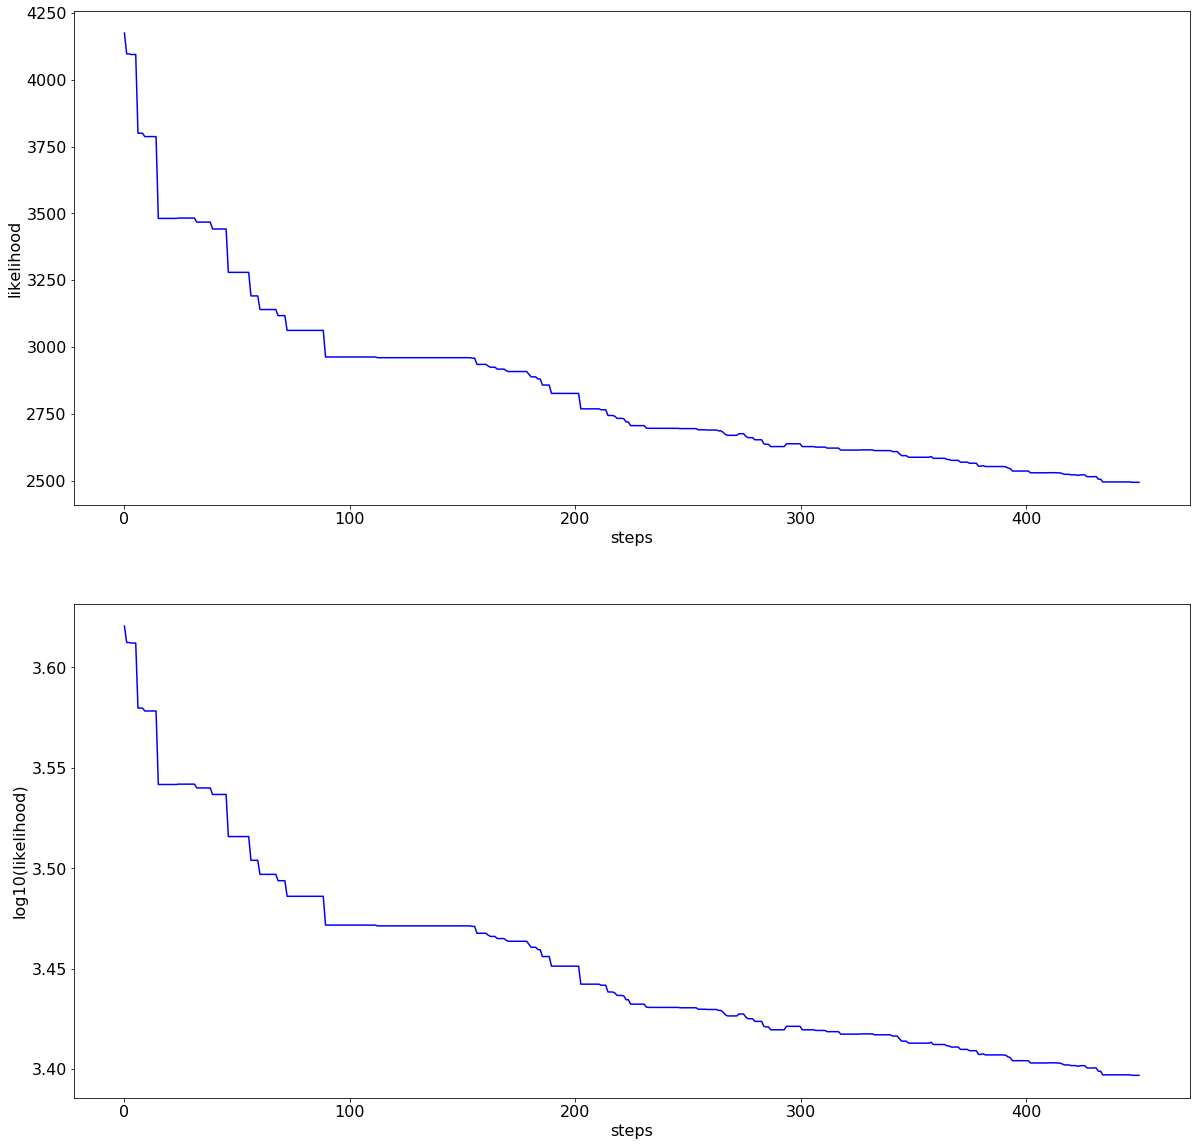

In [2162]:
plt.figure(figsize=(20,20))
plt.subplot(211)
plt.plot(np.linspace(0,len(like_min),len(like_min)),like_min,'blue',ls='-')
plt.ylabel('likelihood')
plt.xlabel('steps')
plt.subplot(212)
plt.plot(np.linspace(0,len(like_min),len(like_min)),np.log10(like_min),'blue',ls='-')
plt.ylabel('log10(likelihood)')
plt.xlabel('steps')

In [2163]:
if obs=='8600':
    model = LN_PFS_single(sci_image,var_image,dithering=2,save=1)
else:
    model = LN_PFS_single(sci_image,var_image,dithering=1,save=1)   
    
model(minchain)

3.0
oversampling of optPSF is: 20.0135710609
oversampling of optPsf_downsampled is: 5


-2493.9099218088818

In [2164]:
print(sci_image[0][0])
print(var_image[0][0])

-11.4209680557
39.3306083679


In [2165]:
optPsf=np.load(TESTING_FINAL_IMAGES_FOLDER+'optPsf.npy')
optPsf_downsampled=np.load(TESTING_FINAL_IMAGES_FOLDER+'optPsf_downsampled.npy')
optPsf_fiber_convolved=np.load(TESTING_FINAL_IMAGES_FOLDER+'optPsf_fiber_convolved.npy')

optPsf_downsampled_scattered=np.load(TESTING_FINAL_IMAGES_FOLDER+'optPsf_downsampled_scattered.npy')

optPsf_cut_fiber_convolved=np.load(TESTING_FINAL_IMAGES_FOLDER+'optPsf_cut_fiber_convolved.npy')
optPsf_cut_pixel_response_convolved=np.load(TESTING_FINAL_IMAGES_FOLDER+'optPsf_cut_pixel_response_convolved.npy')
optPsf_cut_grating_convolved=np.load(TESTING_FINAL_IMAGES_FOLDER+'optPsf_cut_grating_convolved.npy')
optPsf_cut_fiber_convolved_downsampled=np.load(TESTING_FINAL_IMAGES_FOLDER+'optPsf_cut_fiber_convolved_downsampled.npy')
res_iapetus=optPsf_cut_fiber_convolved_downsampled

chi**2 reduced is: 3.107686692
Abs of residual divided by total flux is: 0.0453867612375
Abs of residual divided by largest value of a flux in the image is: 0.0625059558071


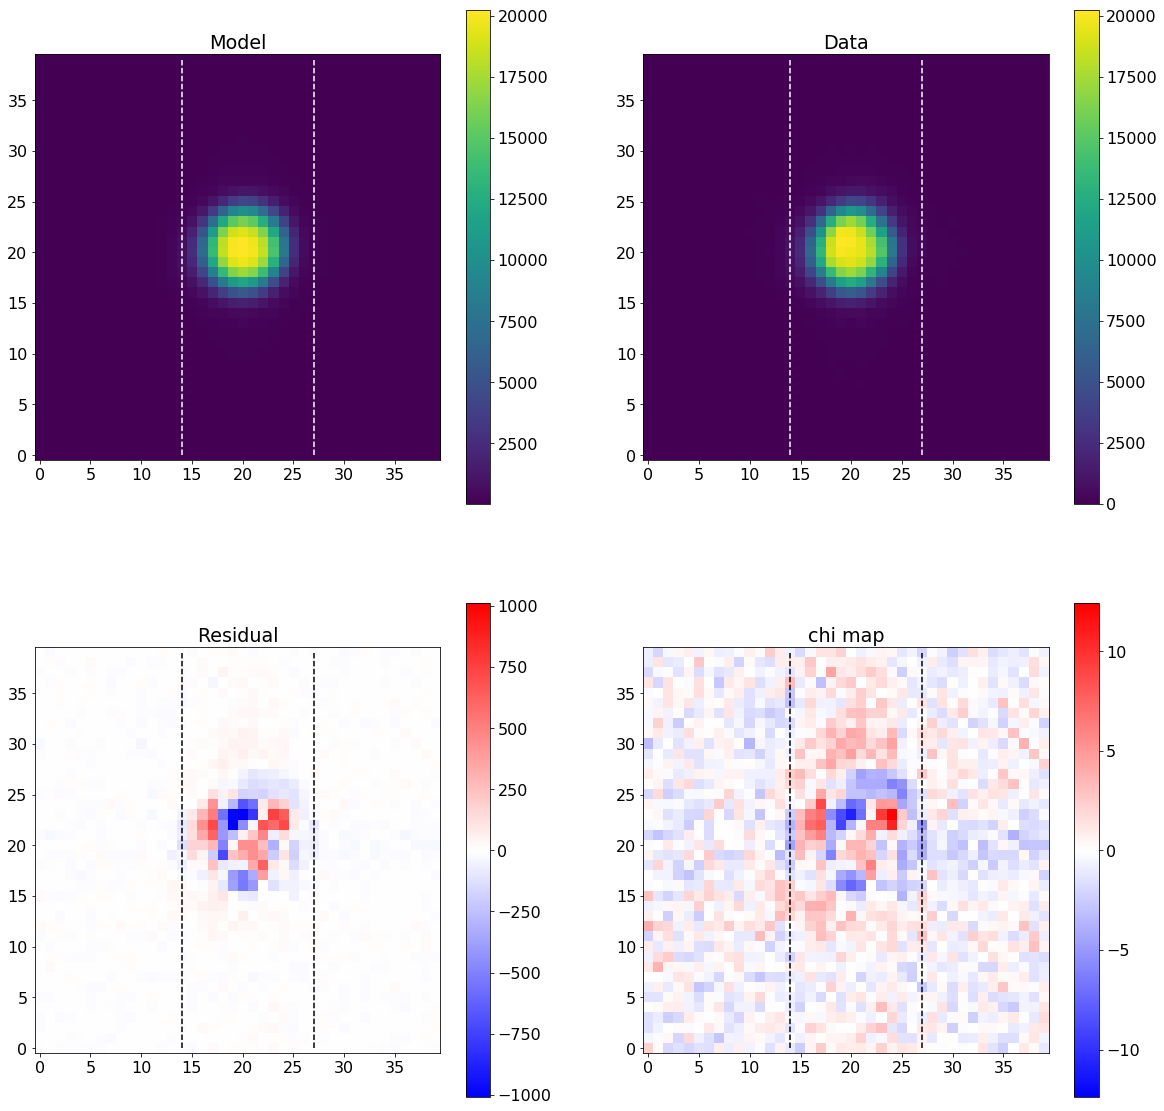

In [2166]:
plt.figure(figsize=(20,20))
plt.subplot(221)
plt.imshow(res_iapetus,origin='lower',vmax=np.max(np.abs(sci_image)))
plt.plot(np.ones(len(sci_image))*14,np.array(range(len(sci_image))),'--',color='white')
plt.plot(np.ones(len(sci_image))*(14+2*6.5),np.array(range(len(sci_image))),'--',color='white')
plt.colorbar()
plt.title('Model')
plt.grid(False)
plt.subplot(222)
plt.imshow(sci_image,origin='lower',vmax=np.max(np.abs(sci_image)))
plt.plot(np.ones(len(sci_image))*14,np.array(range(len(sci_image))),'--',color='white')
plt.plot(np.ones(len(sci_image))*(14+2*6.5),np.array(range(len(sci_image))),'--',color='white')
plt.colorbar()
plt.title('Data')
plt.grid(False)
plt.subplot(223)
plt.imshow(res_iapetus-sci_image,origin='lower',cmap='bwr',vmin=-np.max(np.abs(sci_image))/20,vmax=np.max(np.abs(sci_image))/20)
plt.plot(np.ones(len(sci_image))*14,np.array(range(len(sci_image))),'--',color='black')
plt.plot(np.ones(len(sci_image))*(14+2*6.5),np.array(range(len(sci_image))),'--',color='black')
plt.colorbar()
plt.title('Residual')
plt.grid(False)
plt.subplot(224)
plt.imshow((res_iapetus-sci_image)/np.sqrt(var_image),origin='lower',cmap='bwr',vmax=np.max(np.abs((res_iapetus-sci_image)/np.sqrt(var_image))),vmin=-np.max(np.abs((res_iapetus-sci_image)/np.sqrt(var_image))))
plt.plot(np.ones(len(sci_image))*14,np.array(range(len(sci_image))),'--',color='black')
plt.plot(np.ones(len(sci_image))*(14+2*6.5),np.array(range(len(sci_image))),'--',color='black')
plt.colorbar()
plt.title('chi map')
print('chi**2 reduced is: '+str(np.sum((res_iapetus-sci_image)**2/((var_image.shape[0]*var_image.shape[1])*var_image))))
print('Abs of residual divided by total flux is: '+str(np.sum(np.abs((res_iapetus-sci_image)))/np.sum((res_iapetus))))
print('Abs of residual divided by largest value of a flux in the image is: '+str(np.max(np.abs((res_iapetus-sci_image)/np.max(res_iapetus)))))

In [ ]:
plt.figure(figsize=(20,20))
plt.subplot(221)
plt.imshow(res_iapetus,origin='lower',vmin=1,vmax=np.max(np.abs(sci_image)),norm=LogNorm())
plt.colorbar()
plt.title('Model')
plt.grid(False)
plt.subplot(222)
plt.imshow(sci_image,origin='lower',vmin=1,vmax=np.max(np.abs(sci_image)),norm=LogNorm())
plt.colorbar()
plt.title('Data')
plt.grid(False)
plt.subplot(223)
plt.imshow(np.abs(res_iapetus-sci_image),origin='lower',vmax=np.max(np.abs(sci_image))/20,norm=LogNorm())
plt.colorbar()
plt.title('abs(Residual)')
plt.grid(False)
plt.subplot(224)
plt.imshow((res_iapetus-sci_image)**2/((1)*var_image),origin='lower',vmin=1,norm=LogNorm())
plt.colorbar()
plt.title('chi**2 map')
print(np.sum((res_iapetus-sci_image)**2/((var_image.shape[0]*var_image.shape[1])*var_image)))
np.sum(np.abs((res_iapetus-sci_image)))/np.sum((res_iapetus))

In [2142]:
artifical_noise=np.zeros_like(res_iapetus)
artifical_noise=np.array(artifical_noise)
for i in range(len(artifical_noise)):
    for j in range(len(artifical_noise)):
        artifical_noise[i,j]=np.random.randn()*np.sqrt(var_image[i,j])

3.107686692


0.045386761237477889

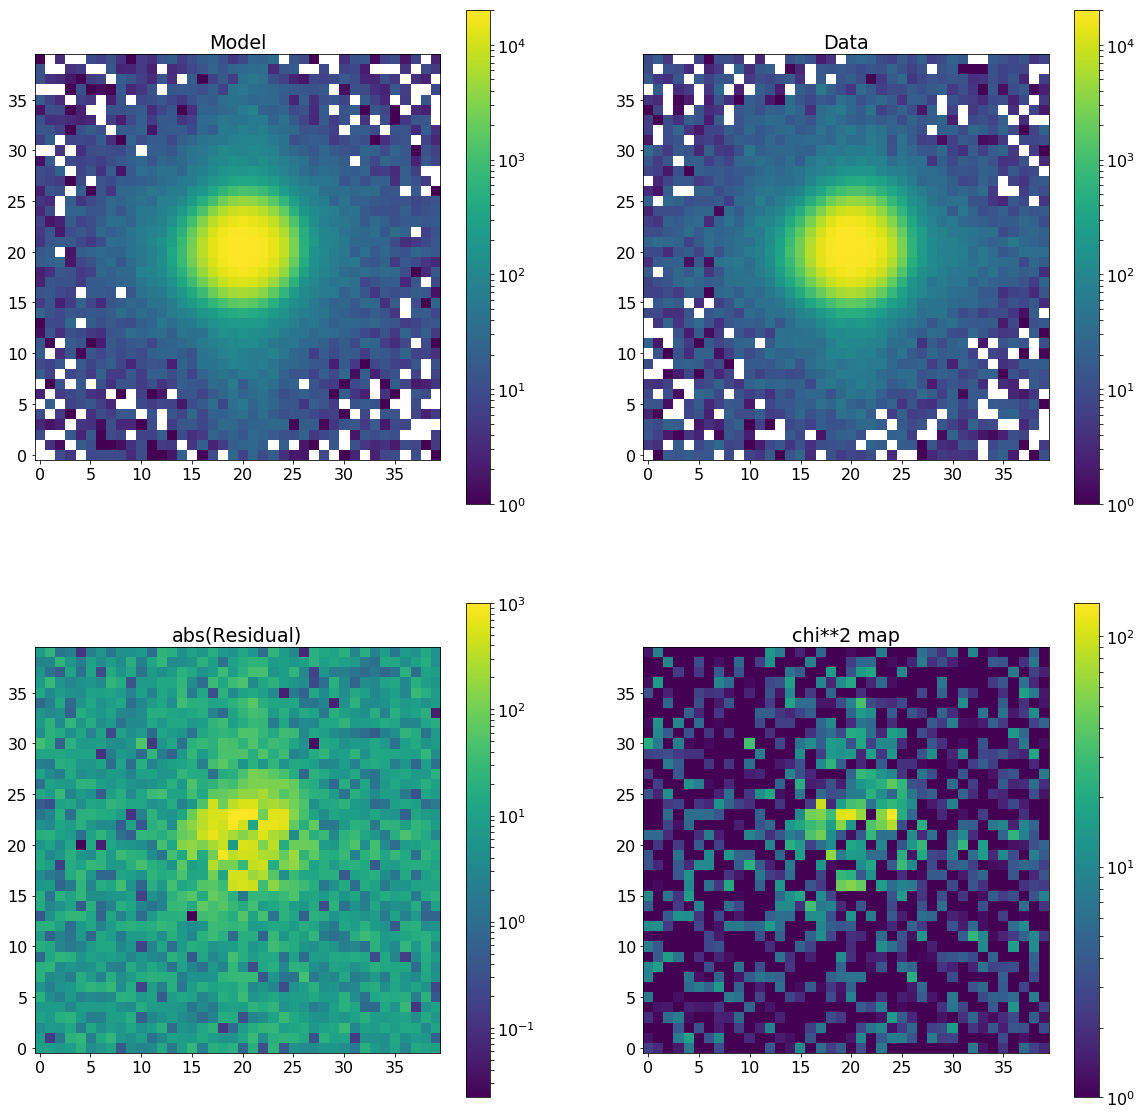

In [2143]:
plt.figure(figsize=(20,20))
plt.subplot(221)
plt.imshow(res_iapetus+artifical_noise,origin='lower',vmin=1,vmax=np.max(np.abs(sci_image)),norm=LogNorm())
plt.colorbar()
plt.title('Model')
plt.grid(False)
plt.subplot(222)
plt.imshow(sci_image,origin='lower',vmin=1,vmax=np.max(np.abs(sci_image)),norm=LogNorm())
plt.colorbar()
plt.title('Data')
plt.grid(False)
plt.subplot(223)
plt.imshow(np.abs(res_iapetus+artifical_noise-sci_image),origin='lower',vmax=np.max(np.abs(sci_image))/20,norm=LogNorm())
plt.colorbar()
plt.title('abs(Residual)')
plt.grid(False)
plt.subplot(224)
plt.imshow((res_iapetus+artifical_noise-sci_image)**2/((1)*var_image),origin='lower',vmin=1,norm=LogNorm())
plt.colorbar()
plt.title('chi**2 map')
print(np.sum((res_iapetus-sci_image)**2/((var_image.shape[0]*var_image.shape[1])*var_image)))
np.sum(np.abs((res_iapetus-sci_image)))/np.sum((res_iapetus))

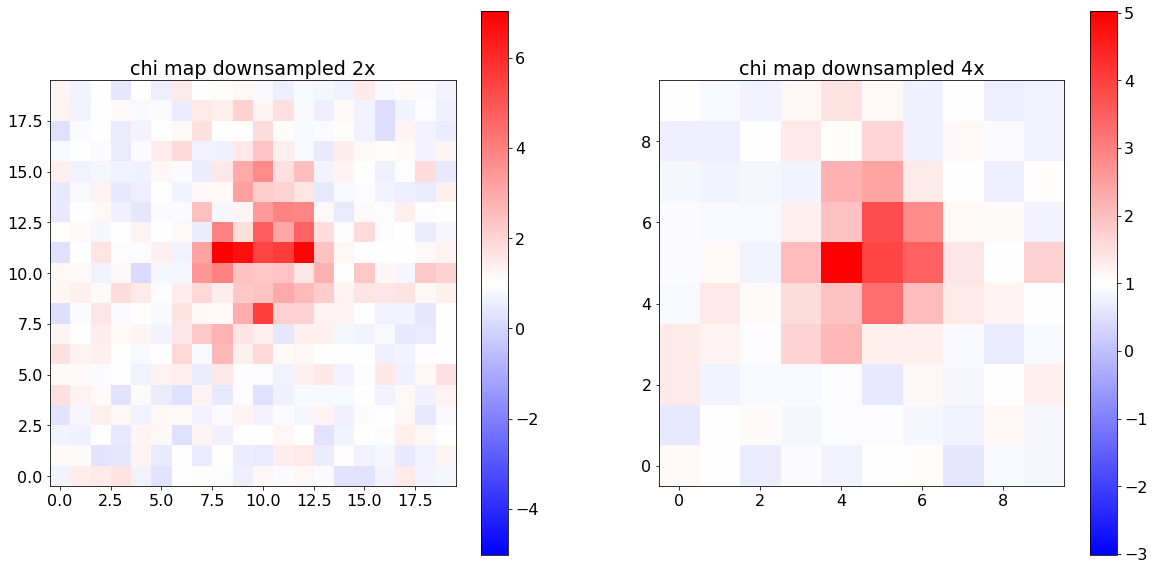

In [2144]:
chi_downsample_10=downsample_manual_function_abs((res_iapetus-sci_image)/np.sqrt(var_image),20)/4
chi_downsample_5=downsample_manual_function_abs((res_iapetus-sci_image)/np.sqrt(var_image),10)/16


plt.figure(figsize=(20,10))
plt.subplot(121)
plt.imshow(chi_downsample_10,origin='lower',cmap='bwr',vmin=1-(np.max(np.abs(chi_downsample_10))-1),vmax=np.max(np.abs(chi_downsample_10)))
plt.colorbar()
plt.title('chi map downsampled 2x')
plt.subplot(122)
plt.imshow(chi_downsample_5,origin='lower',cmap='bwr',vmin=1-(np.max(np.abs(chi_downsample_5))-1),vmax=np.max(np.abs(chi_downsample_5)))
plt.colorbar()
plt.title('chi map downsampled 4x')

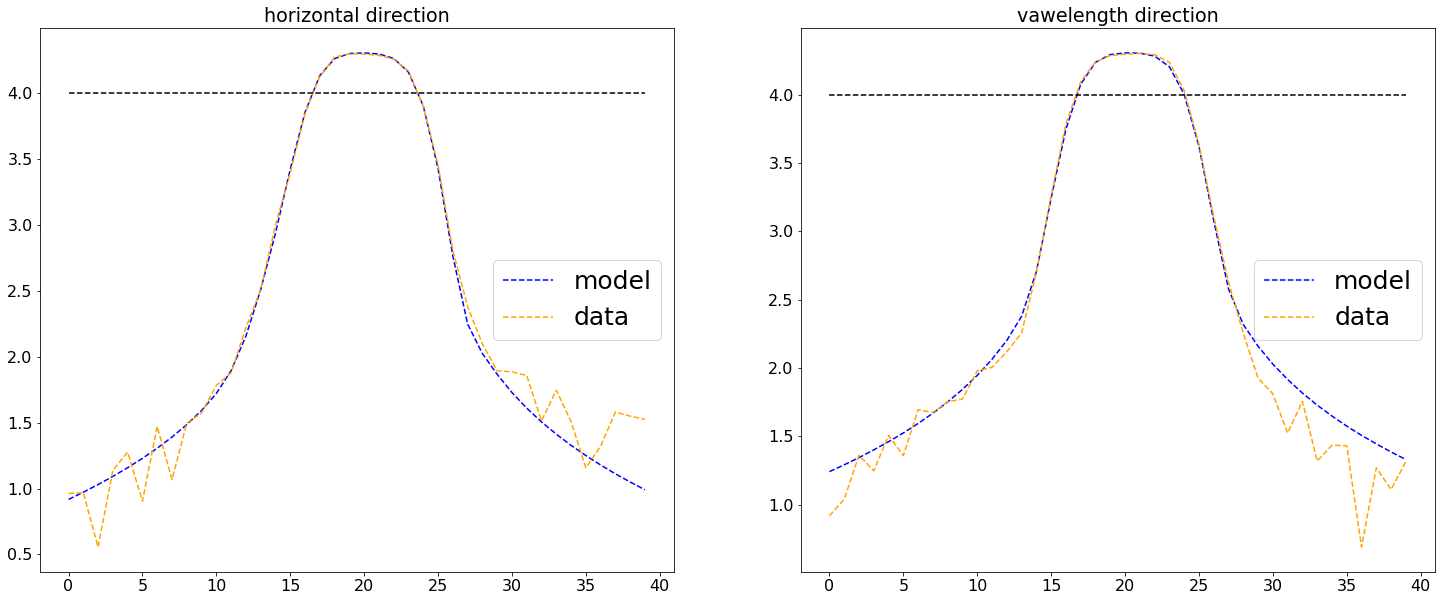

In [1969]:
plt.figure(figsize=(25,10))

plt.subplot(121)
plt.title('horizontal direction')
plt.plot(np.array(range(40)),np.log10(res_iapetus[20]),'blue',linestyle='--',label='model')
plt.plot(np.array(range(40)),np.log10(np.abs(sci_image[20])),'orange',linestyle='--',label='data')
plt.plot(np.array(range(40)),np.ones(40)*np.log10(np.max(sci_image[:,20])*(1/2)),'--',color='black')


plt.legend(fontsize=25)

plt.subplot(122)
plt.title('vawelength direction')
plt.plot(np.array(range(40)),np.log10(res_iapetus[:,20]),'blue',linestyle='--',label='model')
plt.plot(np.array(range(40)),np.log10(np.abs(sci_image[:,20])),'orange',linestyle='--',label='data')
plt.plot(np.array(range(40)),np.ones(40)*np.log10(np.max(sci_image[:,20])*(1/2)),'--',color='black')
plt.legend(fontsize=25)

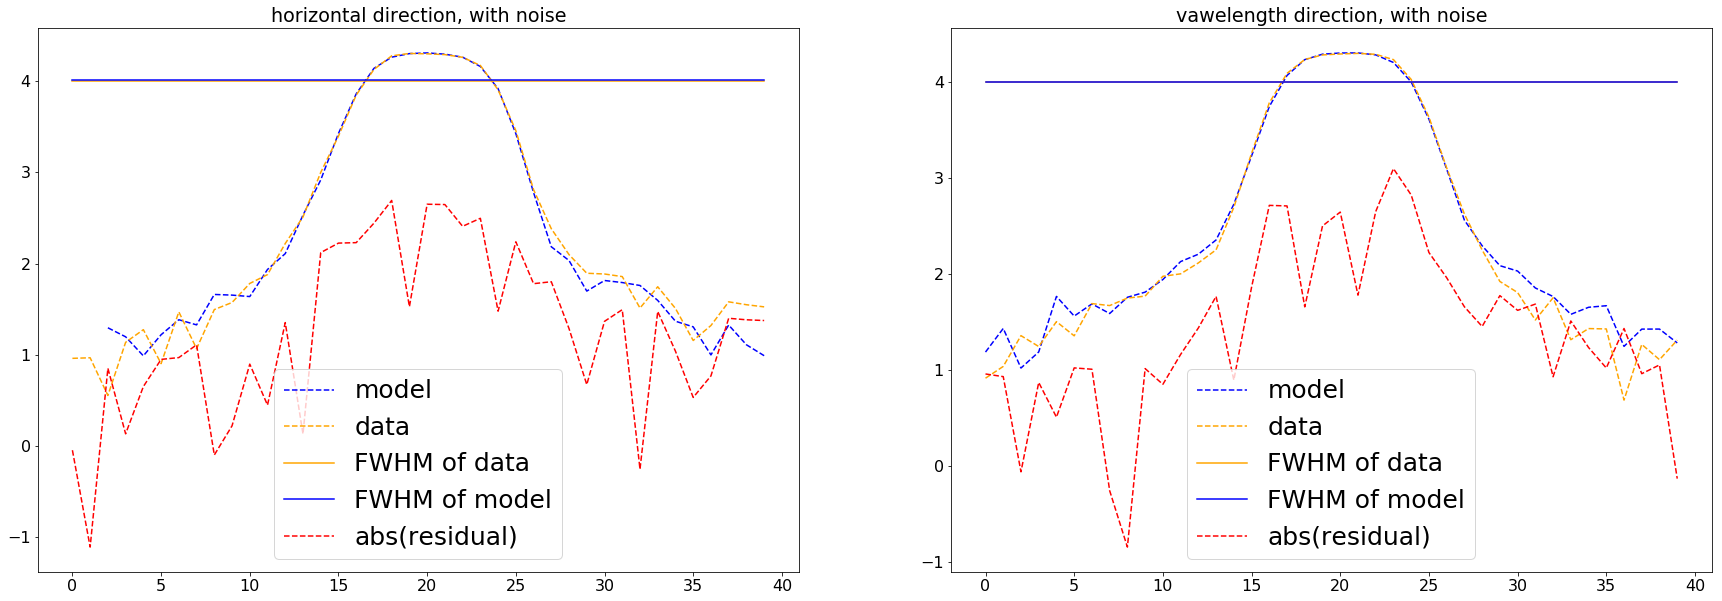

In [1984]:
plt.figure(figsize=(30,10))

plt.subplot(121)
plt.title('horizontal direction, with noise')
plt.plot(np.array(range(40)),np.log10(res_iapetus[20]+artifical_noise[20]),'blue',linestyle='--',label='model')
plt.plot(np.array(range(40)),np.log10(np.abs(sci_image[20])),'orange',linestyle='--',label='data')
plt.plot(np.array(range(40)),np.ones(40)*np.log10(np.max(sci_image[20]*(1/2))),'-',color='orange',label='FWHM of data')
plt.plot(np.array(range(40)),np.ones(40)*np.log10(np.max(res_iapetus[20]*(1/2))),'-',color='blue',label='FWHM of model')
plt.plot(np.array(range(40)),np.log10(np.abs(res_iapetus[20]-sci_image[20])),'red',linestyle='--',label='abs(residual)')
plt.legend(fontsize=25)

plt.subplot(122)
plt.title('vawelength direction, with noise')
plt.plot(np.array(range(40)),np.log10(res_iapetus[:,20]+artifical_noise[:,20]),'blue',linestyle='--',label='model')
plt.plot(np.array(range(40)),np.log10(np.abs(sci_image[:,20])),'orange',linestyle='--',label='data')
plt.plot(np.array(range(40)),np.ones(40)*np.log10(np.max(sci_image[:,20]*(1/2))),'-',color='orange',label='FWHM of data')
plt.plot(np.array(range(40)),np.ones(40)*np.log10(np.max(res_iapetus[:,20]*(1/2))),'-',color='blue',label='FWHM of model')
plt.plot(np.array(range(40)),np.log10(np.abs(res_iapetus[:,20]-sci_image[:,20])),'red',linestyle='--',label='abs(residual)')
plt.legend(fontsize=25)

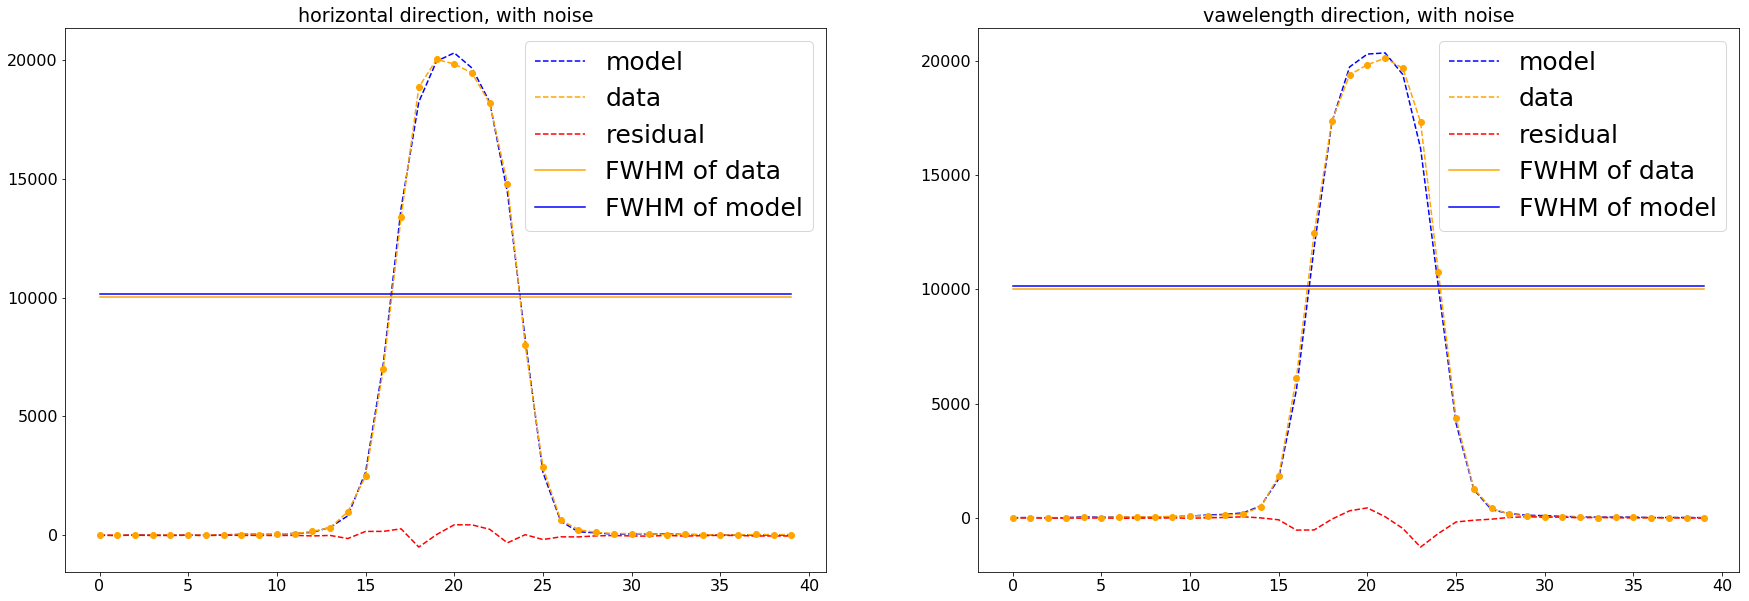

In [1978]:
plt.figure(figsize=(30,10))

plt.subplot(121)
plt.title('horizontal direction, with noise')
plt.plot(np.array(range(40)),res_iapetus[20]+artifical_noise[20],'blue',linestyle='--',label='model')
plt.plot(np.array(range(40)),sci_image[20],'orange',linestyle='--',label='data')
plt.plot(np.array(range(40)),res_iapetus[20]-sci_image[20],'red',linestyle='--',label='residual')
plt.errorbar(np.array(range(40)),sci_image[20],yerr=1*np.sqrt(var_image[20]),color='orange',fmt='o')
plt.plot(np.array(range(40)),np.ones(40)*np.max(sci_image[20]*(1/2)),'-',color='orange',label='FWHM of data')
plt.plot(np.array(range(40)),np.ones(40)*np.max(res_iapetus[20]*(1/2)),'-',color='blue',label='FWHM of model')
plt.legend(fontsize=25)

plt.subplot(122)
plt.title('vawelength direction, with noise')
plt.plot(np.array(range(40)),res_iapetus[:,20]+artifical_noise[:,20],'blue',linestyle='--',label='model')
plt.plot(np.array(range(40)),sci_image[:,20],'orange',linestyle='--',label='data')
plt.plot(np.array(range(40)),res_iapetus[:,20]-sci_image[:,20],'red',linestyle='--',label='residual')
plt.errorbar(np.array(range(40)),sci_image[:,20],yerr=1*np.sqrt(var_image[:,20]),color='orange',fmt='o')
plt.plot(np.array(range(40)),np.ones(40)*np.max(sci_image[20]*(1/2)),'-',color='orange',label='FWHM of data')
plt.plot(np.array(range(40)),np.ones(40)*np.max(res_iapetus[20]*(1/2)),'-',color='blue',label='FWHM of model')
plt.legend(fontsize=25)

In [1972]:
IMAGES_FOLDER='/Users/nevencaplar/Documents/PFS/Images/'+date+'/'
if not os.path.exists(IMAGES_FOLDER):
    os.makedirs(IMAGES_FOLDER)
IMAGES_FOLDER

'/Users/nevencaplar/Documents/PFS/Images/Aug21/'

In [1973]:
%%capture
import corner

matplotlib.rcParams.update({'font.size': 16})
flatchain0=np.reshape(chain0_Emcee3,(chain0_Emcee3.shape[0]*chain0_Emcee3.shape[1],chain0_Emcee3.shape[2]))

figure=corner.corner(flatchain0[:,0:8], labels=columns[0:8],
                  truths=list(minchain[0:8]))
figure.savefig(IMAGES_FOLDER+'zparameters.png')

In [1974]:
%%capture
matplotlib.rcParams.update({'font.size': 16})
flatchain0=np.reshape(chain0_Emcee3,(chain0_Emcee3.shape[0]*chain0_Emcee3.shape[1],chain0_Emcee3.shape[2]))

figure=corner.corner(flatchain0[:,8:], labels=columns[8:],
                  truths=list(minchain[8:]))
figure.savefig(IMAGES_FOLDER+'/globalparameters.png')

## Moving dithered result to non-dithered image

In [2074]:
obs='8603'
single_number='55'
image_index=int(single_number)
eps=1
date='Aug21'

RESULT_FOLDER='/Users/nevencaplar/Documents/PFS/TigerAnalysis/ResultsFromTiger/'+date+'/'


if obs=='8600':
    sci_image=np.load("/Users/nevencaplar/Documents/PFS/TigerAnalysis/CutsForTigerAug15/sci"+str(obs)+str(image_index)+'Stacked_Cleaned_Dithered.npy')
    var_image=np.load("/Users/nevencaplar/Documents/PFS/TigerAnalysis/CutsForTigerAug15/var"+str(obs)+str(image_index)+'Stacked_Dithered.npy')
else:       
    sci_image=np.load("/Users/nevencaplar/Documents/PFS/TigerAnalysis/CutsForTigerAug15/sci"+str(obs)+str(image_index)+'Stacked_Cleaned.npy')
    var_image=np.load("/Users/nevencaplar/Documents/PFS/TigerAnalysis/CutsForTigerAug15/var"+str(obs)+str(image_index)+'Stacked.npy')


In [2075]:
#make sure that minchain is from the 8600 analysis!

if obs=='8600':
    model = LN_PFS_single(sci_image,var_image,dithering=2,save=1)
else:
    model = LN_PFS_single(sci_image,var_image,dithering=1,save=1)   
    
model(minchain)

1.5
oversampling of optPSF is: 40.0271421218
oversampling of optPsf_downsampled is: 10


-1673.1549063115594

In [2069]:
optPsf=np.load(TESTING_FINAL_IMAGES_FOLDER+'optPsf.npy')
optPsf_downsampled=np.load(TESTING_FINAL_IMAGES_FOLDER+'optPsf_downsampled.npy')
optPsf_fiber_convolved=np.load(TESTING_FINAL_IMAGES_FOLDER+'optPsf_fiber_convolved.npy')

optPsf_downsampled_scattered=np.load(TESTING_FINAL_IMAGES_FOLDER+'optPsf_downsampled_scattered.npy')

optPsf_cut_fiber_convolved=np.load(TESTING_FINAL_IMAGES_FOLDER+'optPsf_cut_fiber_convolved.npy')
optPsf_cut_pixel_response_convolved=np.load(TESTING_FINAL_IMAGES_FOLDER+'optPsf_cut_pixel_response_convolved.npy')
optPsf_cut_grating_convolved=np.load(TESTING_FINAL_IMAGES_FOLDER+'optPsf_cut_grating_convolved.npy')
optPsf_cut_fiber_convolved_downsampled=np.load(TESTING_FINAL_IMAGES_FOLDER+'optPsf_cut_fiber_convolved_downsampled.npy')
res_iapetus=optPsf_cut_fiber_convolved_downsampled

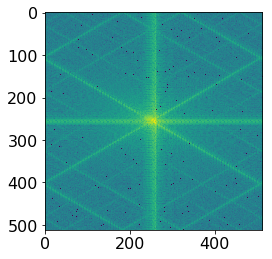

In [2083]:
plt.imshow(optPsf_downsampled,norm=LogNorm())

In [2084]:
np.sum(optPsf_downsampled)

24363704045.572411

chi**2 reduced is: 8.32922895023
Abs of residual divided by total flux is: 0.0503824790903
Abs of residual divided by largest value of a flux in the image is: 0.0572505504788


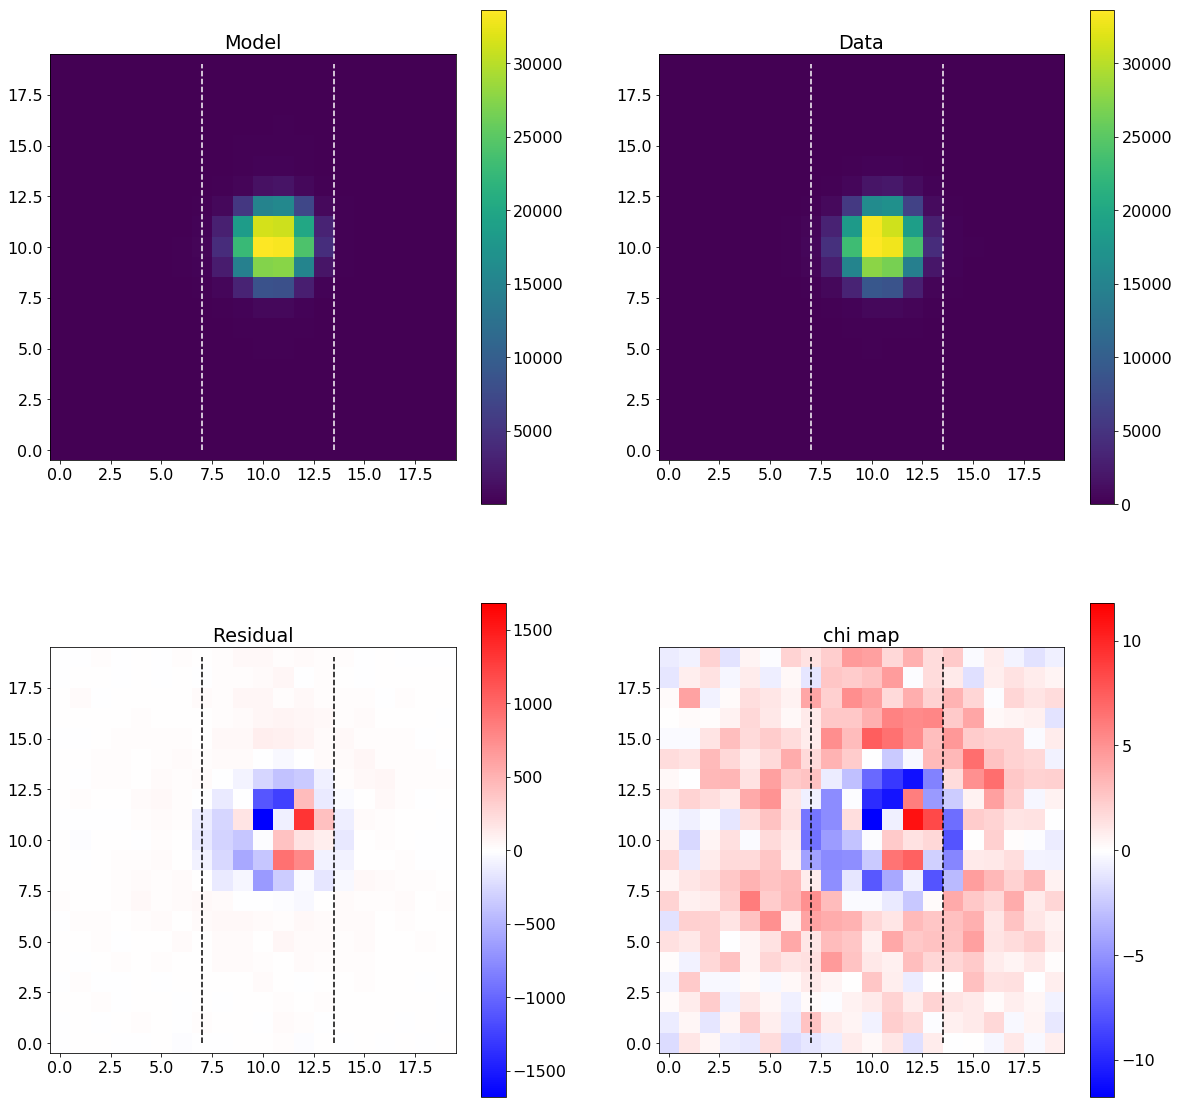

In [2070]:
plt.figure(figsize=(20,20))
plt.subplot(221)
plt.imshow(res_iapetus,origin='lower',vmax=np.max(np.abs(sci_image)))
plt.plot(np.ones(20)*7,np.array(range(20)),'--',color='white')
plt.plot(np.ones(20)*(7+6.5),np.array(range(20)),'--',color='white')
plt.colorbar()
plt.title('Model')
plt.grid(False)
plt.subplot(222)
plt.imshow(sci_image,origin='lower',vmax=np.max(np.abs(sci_image)))
plt.plot(np.ones(20)*7,np.array(range(20)),'--',color='white')
plt.plot(np.ones(20)*(7+6.5),np.array(range(20)),'--',color='white')
plt.colorbar()
plt.title('Data')
plt.grid(False)
plt.subplot(223)

plt.imshow(res_iapetus-sci_image,origin='lower',cmap='bwr',vmin=-np.max(np.abs(sci_image))/20,vmax=np.max(np.abs(sci_image))/20)
plt.plot(np.ones(20)*7,np.array(range(20)),'--',color='black')
plt.plot(np.ones(20)*(7+6.5),np.array(range(20)),'--',color='black')
plt.colorbar()
plt.title('Residual')
plt.grid(False)
plt.subplot(224)
plt.imshow((res_iapetus-sci_image)/np.sqrt(var_image),origin='lower',cmap='bwr',vmax=np.max(np.abs((res_iapetus-sci_image)/np.sqrt(var_image))),vmin=-np.max(np.abs((res_iapetus-sci_image)/np.sqrt(var_image))))
plt.plot(np.ones(20)*7,np.array(range(20)),'--',color='black')
plt.plot(np.ones(20)*(7+6.5),np.array(range(20)),'--',color='black')
plt.colorbar()
plt.title('chi map')
print('chi**2 reduced is: '+str(np.sum((res_iapetus-sci_image)**2/((var_image.shape[0]*var_image.shape[1])*var_image))))
print('Abs of residual divided by total flux is: '+str(np.sum(np.abs((res_iapetus-sci_image)))/np.sum((res_iapetus))))
print('Abs of residual divided by largest value of a flux in the image is: '+str(np.max(np.abs((res_iapetus-sci_image)/np.max(res_iapetus)))))

8.32922895023


0.050382479090260883

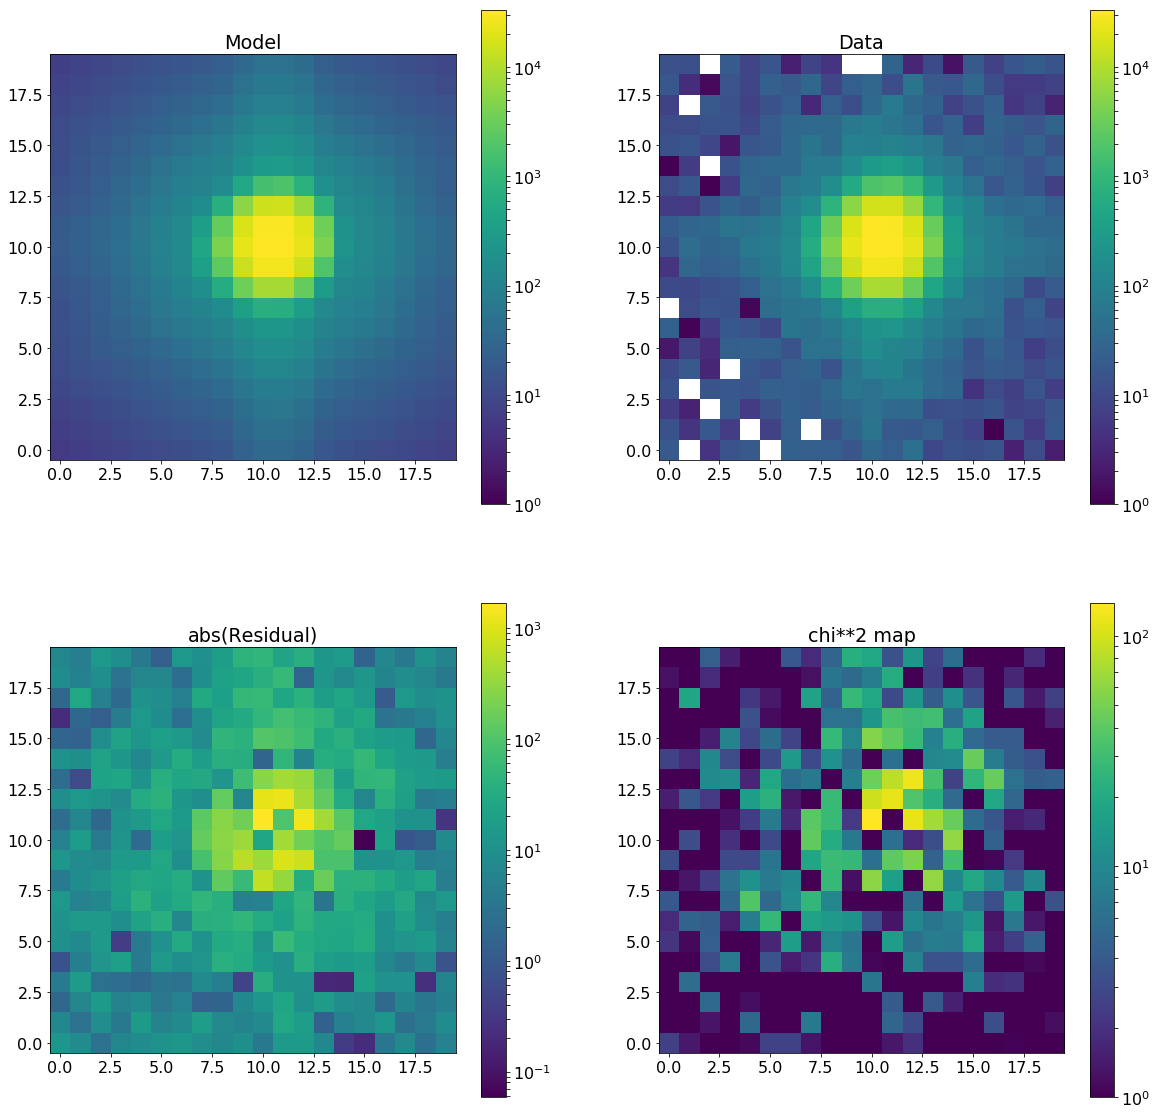

In [2071]:
plt.figure(figsize=(20,20))
plt.subplot(221)
plt.imshow(res_iapetus,origin='lower',vmin=1,vmax=np.max(np.abs(sci_image)),norm=LogNorm())
plt.colorbar()
plt.title('Model')
plt.grid(False)
plt.subplot(222)
plt.imshow(sci_image,origin='lower',vmin=1,vmax=np.max(np.abs(sci_image)),norm=LogNorm())
plt.colorbar()
plt.title('Data')
plt.grid(False)
plt.subplot(223)
plt.imshow(np.abs(res_iapetus-sci_image),origin='lower',vmax=np.max(np.abs(sci_image))/20,norm=LogNorm())
plt.colorbar()
plt.title('abs(Residual)')
plt.grid(False)
plt.subplot(224)
plt.imshow((res_iapetus-sci_image)**2/((1)*var_image),origin='lower',vmin=1,norm=LogNorm())
plt.colorbar()
plt.title('chi**2 map')
print(np.sum((res_iapetus-sci_image)**2/((var_image.shape[0]*var_image.shape[1])*var_image)))
np.sum(np.abs((res_iapetus-sci_image)))/np.sum((res_iapetus))

In [2072]:
artifical_noise=np.zeros_like(res_iapetus)
artifical_noise=np.array(artifical_noise)
for i in range(len(artifical_noise)):
    for j in range(len(artifical_noise)):
        artifical_noise[i,j]=np.random.randn()*np.sqrt(var_image[i,j])

8.32922895023


0.050382479090260883

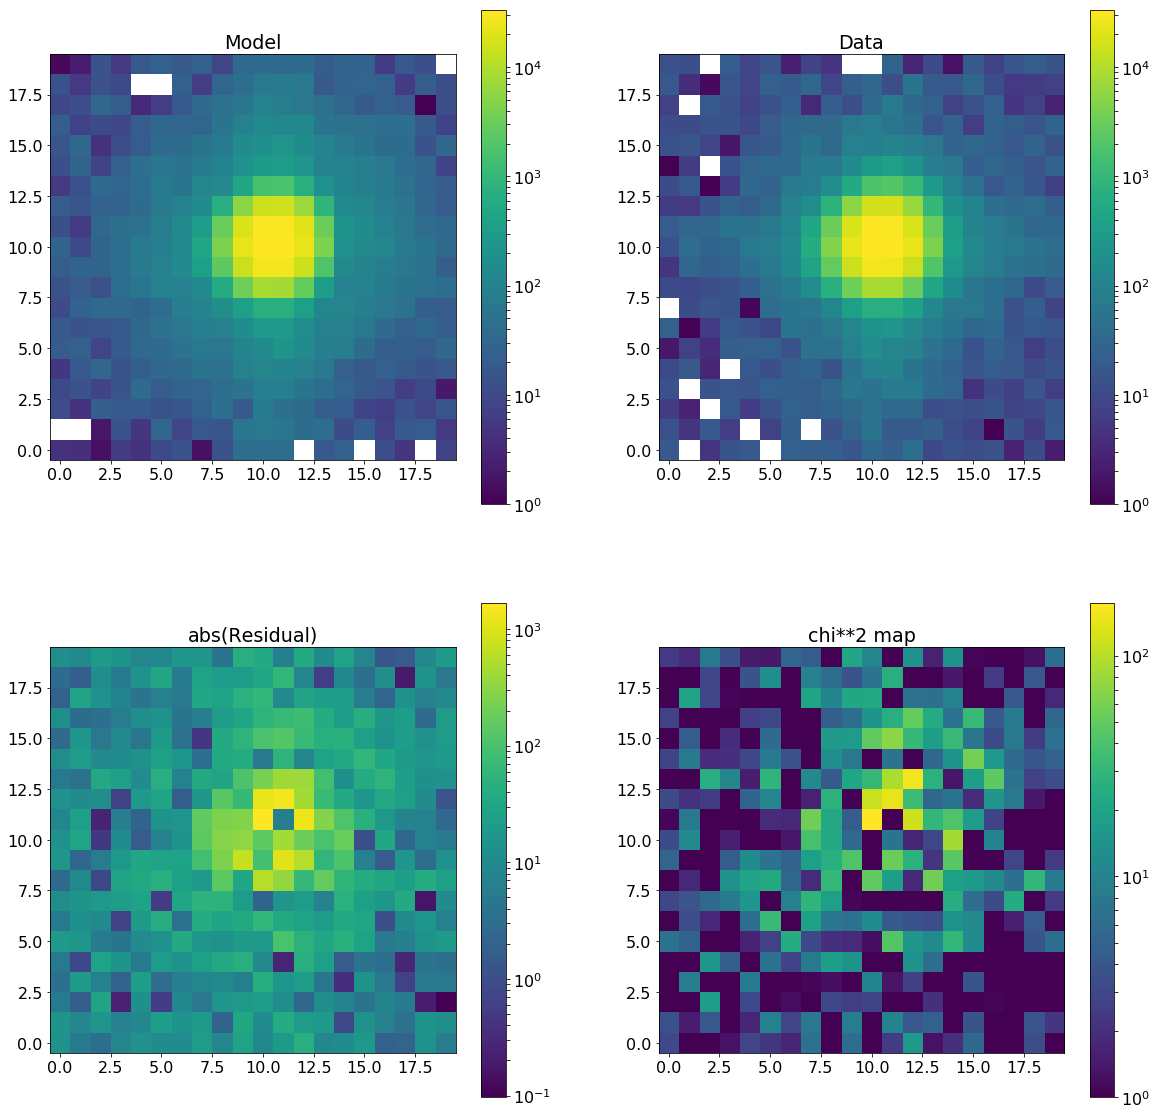

In [2073]:
plt.figure(figsize=(20,20))
plt.subplot(221)
plt.imshow(res_iapetus+artifical_noise,origin='lower',vmin=1,vmax=np.max(np.abs(sci_image)),norm=LogNorm())
plt.colorbar()
plt.title('Model')
plt.grid(False)
plt.subplot(222)
plt.imshow(sci_image,origin='lower',vmin=1,vmax=np.max(np.abs(sci_image)),norm=LogNorm())
plt.colorbar()
plt.title('Data')
plt.grid(False)
plt.subplot(223)
plt.imshow(np.abs(res_iapetus+artifical_noise-sci_image),origin='lower',vmax=np.max(np.abs(sci_image))/20,norm=LogNorm())
plt.colorbar()
plt.title('abs(Residual)')
plt.grid(False)
plt.subplot(224)
plt.imshow((res_iapetus+artifical_noise-sci_image)**2/((1)*var_image),origin='lower',vmin=1,norm=LogNorm())
plt.colorbar()
plt.title('chi**2 map')
print(np.sum((res_iapetus-sci_image)**2/((var_image.shape[0]*var_image.shape[1])*var_image)))
np.sum(np.abs((res_iapetus-sci_image)))/np.sum((res_iapetus))

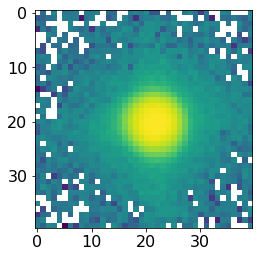

In [2177]:
sci_image=np.load("/Users/nevencaplar/Documents/PFS/TigerAnalysis/CutsForTigerAug15/sci"+str(8600)+str(99)+'Stacked_Cleaned_Dithered.npy')
plt.imshow(sci_image,norm=LogNorm())

## Result of predictions 

In [2001]:
solution_at_0=[]
for q in columns:
    z4_arr=np.array(results_of_fit_single[q])
    z4_arr_err=np.array(err_results_of_fit_single[q])
    popt, pcov = curve_fit(lin_fit_1D, index_arr, z4_arr, sigma=z4_arr_err)
    
    index_arr=np.array(results_of_fit_single.index.values)
    index_arr=np.array(map(float,index_arr))
    
    fit_res=[]
    if q[0] == 'z':
        popt, pcov = curve_fit(lin_fit_1D, index_arr, z4_arr, sigma=z4_arr_err)
        for i in np.linspace(-2.5,2.5,11):
            fit_res.append(lin_fit_1D(i,popt[0],popt[1]))
    else:
        popt, pcov = curve_fit(lin_fit_1DConstant, index_arr, z4_arr, sigma=z4_arr_err)
        for i in np.linspace(-2.5,2.5,11):
            fit_res.append(lin_fit_1DConstant(i,popt[0]))

    solution_at_0.append(fit_res[5])

    
solution_at_0=np.array(solution_at_0)

KeyError: 'fiber_r'

## Studying exposure in the center  - keep images from before fiber_r was introduced again

4.48965723006


0.064152786570766659

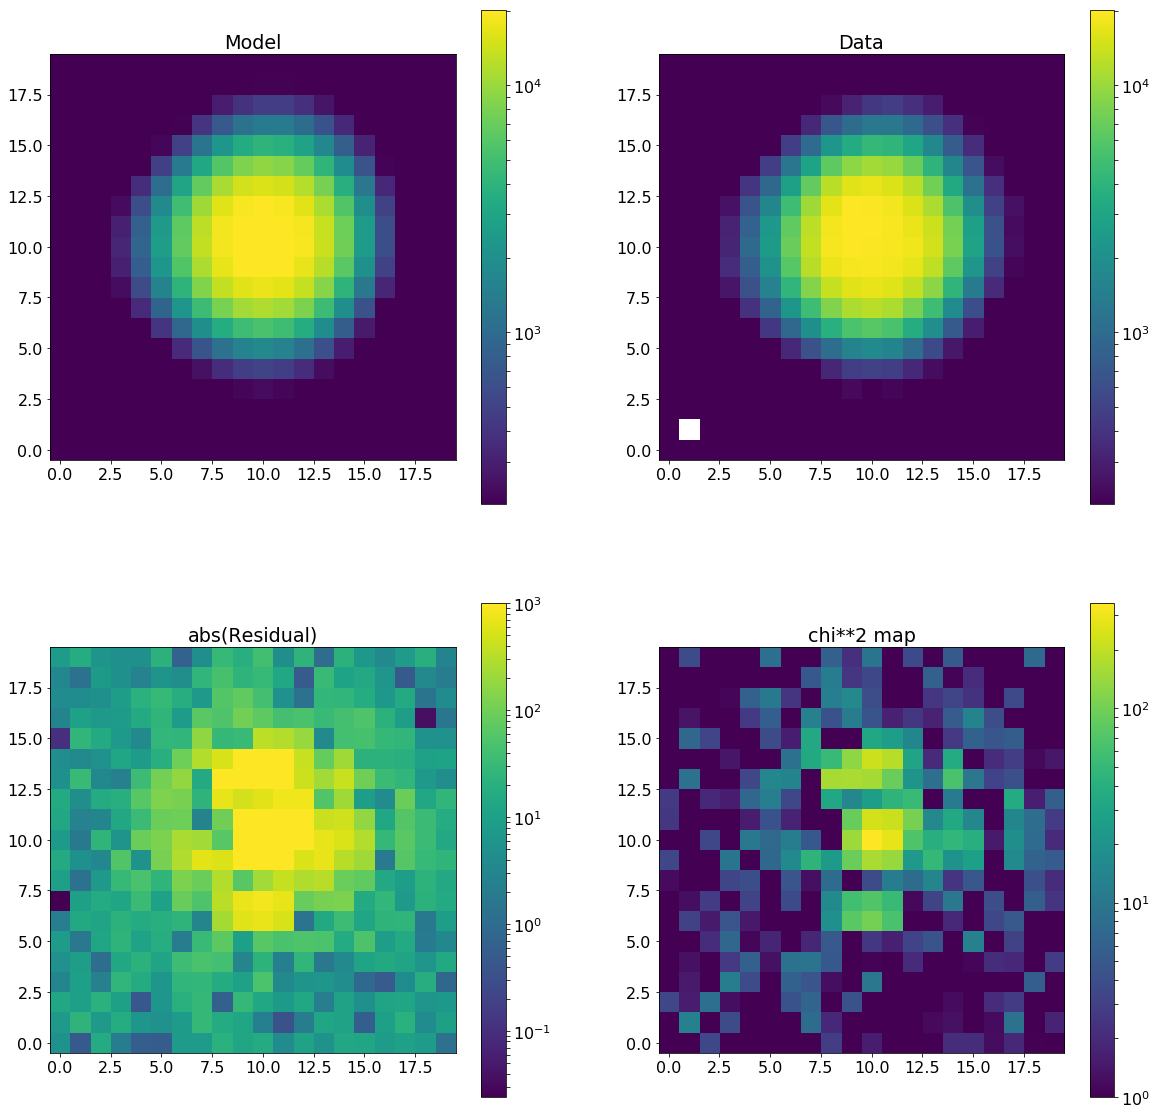

In [1821]:
plt.figure(figsize=(20,20))
plt.subplot(221)
plt.imshow(res_iapetus[10:30,10:30],origin='lower',vmin=np.max(np.abs(sci_image))/100,vmax=np.max(np.abs(sci_image)),norm=LogNorm())
plt.colorbar()
plt.title('Model')
plt.grid(False)
plt.subplot(222)
plt.imshow(sci_image[10:30,10:30],origin='lower',vmin=np.max(np.abs(sci_image))/100,vmax=np.max(np.abs(sci_image)),norm=LogNorm())
plt.colorbar()
plt.title('Data')
plt.grid(False)
plt.subplot(223)
plt.imshow(np.abs(res_iapetus[10:30,10:30]-sci_image[10:30,10:30]),origin='lower',vmax=np.max(np.abs(sci_image))/20,norm=LogNorm())
plt.colorbar()
plt.title('abs(Residual)')
plt.grid(False)
plt.subplot(224)
plt.imshow((res_iapetus[10:30,10:30]-sci_image[10:30,10:30])**2/((1)*var_image[10:30,10:30]),origin='lower',vmin=1,norm=LogNorm())
plt.colorbar()
plt.title('chi**2 map')
print(np.sum((res_iapetus-sci_image)**2/((var_image.shape[0]*var_image.shape[1])*var_image)))
np.sum(np.abs((res_iapetus-sci_image)))/np.sum((res_iapetus))

4.48965723006


0.064152786570766659

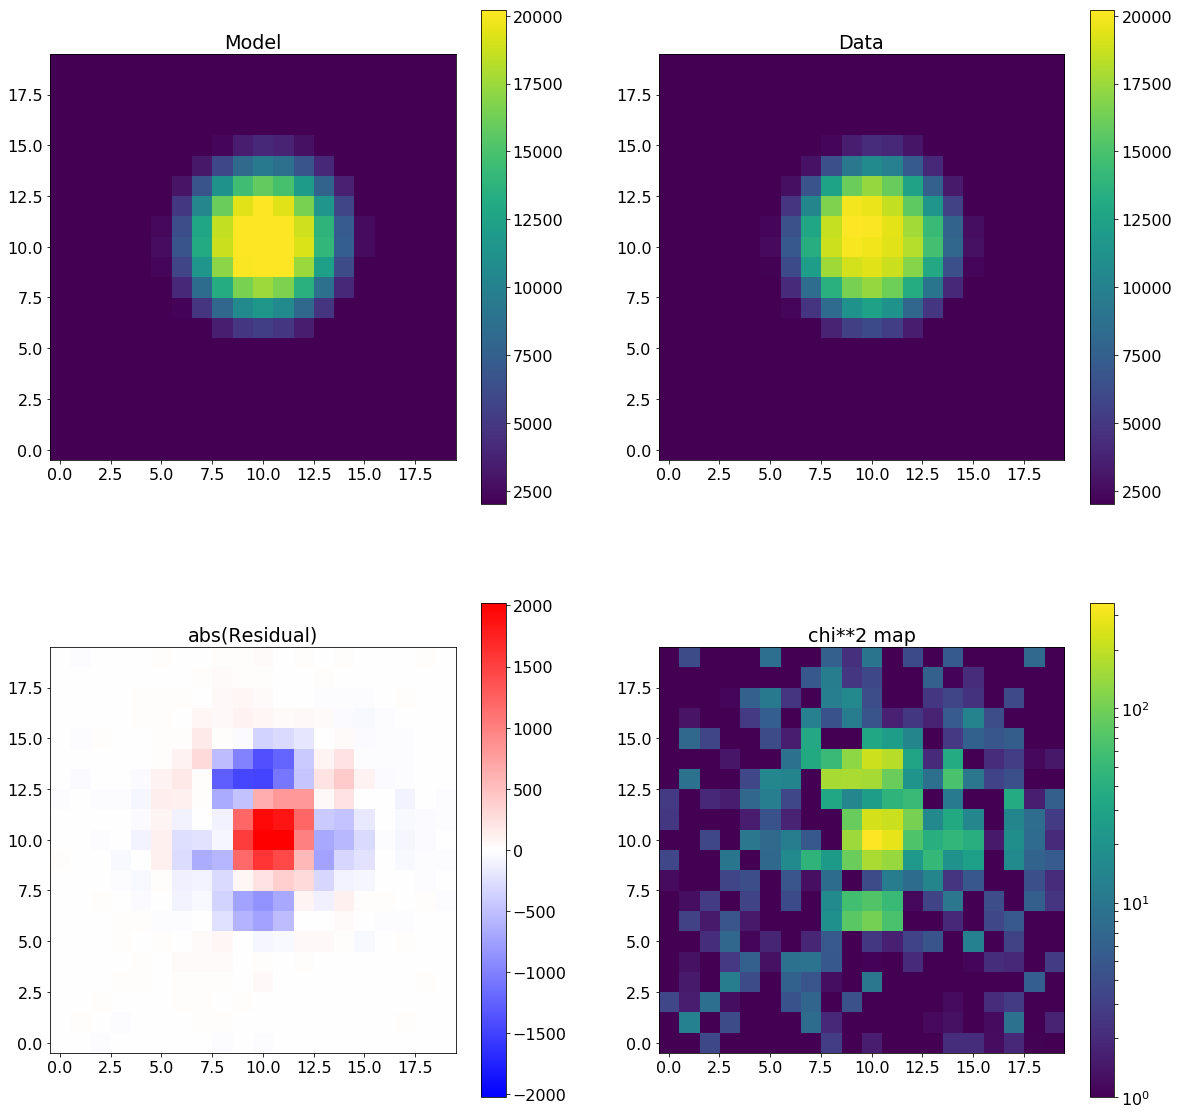

In [1822]:
plt.figure(figsize=(20,20))
plt.subplot(221)
plt.imshow(res_iapetus[10:30,10:30],origin='lower',vmin=np.max(np.abs(sci_image))/10,vmax=np.max(np.abs(sci_image)))
plt.colorbar()
plt.title('Model')
plt.grid(False)
plt.subplot(222)
plt.imshow(sci_image[10:30,10:30],origin='lower',vmin=np.max(np.abs(sci_image))/10,vmax=np.max(np.abs(sci_image)))
plt.colorbar()
plt.title('Data')
plt.grid(False)
plt.subplot(223)
plt.imshow(res_iapetus[10:30,10:30]-sci_image[10:30,10:30],origin='lower',cmap='bwr',vmin=-np.max(np.abs(sci_image))/10,vmax=np.max(np.abs(sci_image))/10)
plt.colorbar()
plt.title('abs(Residual)')
plt.grid(False)
plt.subplot(224)
plt.imshow((res_iapetus[10:30,10:30]-sci_image[10:30,10:30])**2/((1)*var_image[10:30,10:30]),origin='lower',vmin=1,norm=LogNorm())
plt.colorbar()
plt.title('chi**2 map')
print(np.sum((res_iapetus-sci_image)**2/((var_image.shape[0]*var_image.shape[1])*var_image)))
np.sum(np.abs((res_iapetus-sci_image)))/np.sum((res_iapetus))

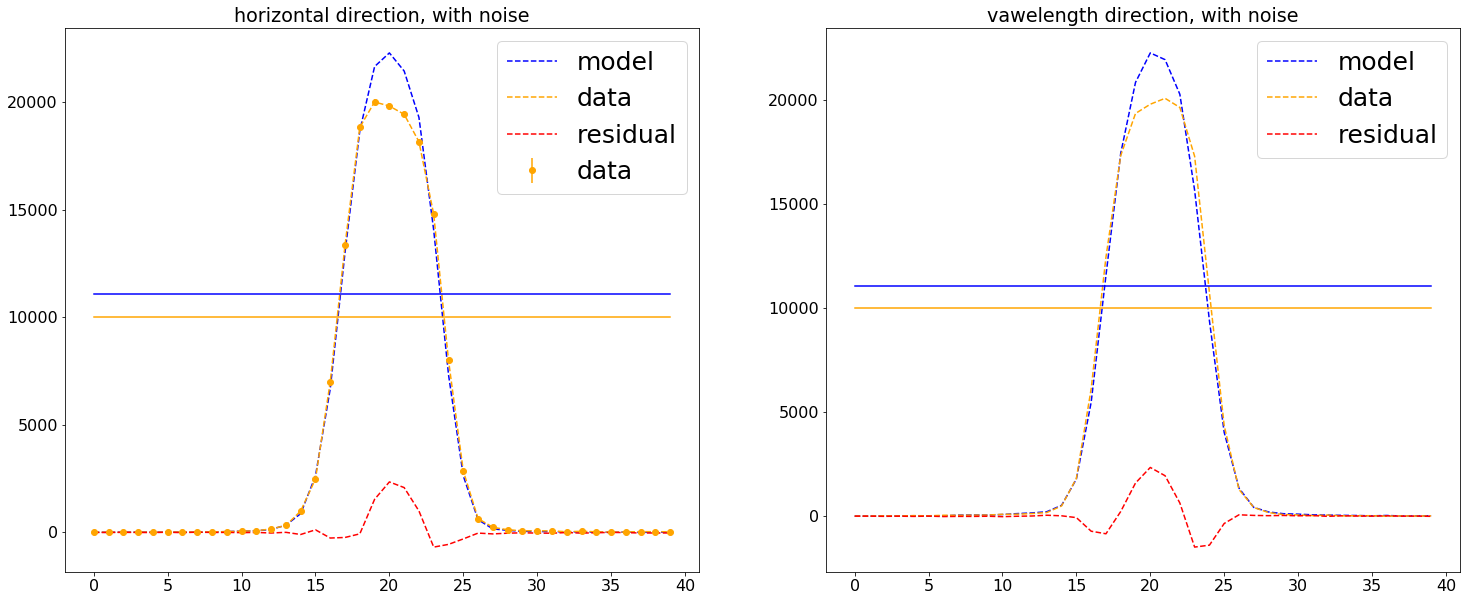

In [1823]:
plt.figure(figsize=(25,10))

plt.subplot(121)
plt.title('horizontal direction, with noise')
plt.plot(np.array(range(40)),res_iapetus[20]+artifical_noise[20],'blue',linestyle='--',label='model')
plt.plot(np.array(range(40)),sci_image[20],'orange',linestyle='--',label='data')
plt.plot(np.array(range(40)),res_iapetus[20]-sci_image[20],'red',linestyle='--',label='residual')
plt.errorbar(np.array(range(40)),sci_image[20],yerr=1*np.sqrt(var_image[20]),color='orange',label='data',fmt='o')
plt.plot(np.array(range(40)),np.ones(40)*np.max(sci_image[20]*(1/2)),'-',color='orange')
plt.plot(np.array(range(40)),np.ones(40)*np.max(res_iapetus[20]*(1/2)),'-',color='blue')
plt.legend(fontsize=25)

plt.subplot(122)
plt.title('vawelength direction, with noise')
plt.plot(np.array(range(40)),res_iapetus[:,20]+artifical_noise[:,20],'blue',linestyle='--',label='model')
plt.plot(np.array(range(40)),sci_image[:,20],'orange',linestyle='--',label='data')
plt.plot(np.array(range(40)),res_iapetus[:,20]-sci_image[:,20],'red',linestyle='--',label='residual')
plt.plot(np.array(range(40)),np.ones(40)*np.max(sci_image[20]*(1/2)),'-',color='orange')
plt.plot(np.array(range(40)),np.ones(40)*np.max(res_iapetus[20]*(1/2)),'-',color='blue')
plt.legend(fontsize=25)

<Container object of 3 artists>

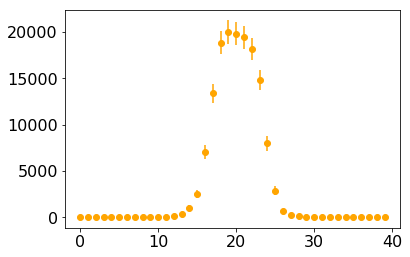

In [1824]:
plt.errorbar(np.array(range(40)),sci_image[20],yerr=10*np.sqrt(var_image[20]),color='orange',label='data',fmt='o')


## problem of center, trying to understand  - I think I need fiber_r freedom

In [1916]:

columns=['z4','z5','z6','z7','z8','z9','z10','z11',
                      'hscFrac','strutFrac','dxFocal','dyFocal','slitFrac','slitFrac_dy',
                      'radiometricEffect','radiometricExponent',
                      'x_ilum','y_ilum','minorAxis','pupilAngle',
                      'grating_lines','scattering_radius','scattering_slope','scattering_amplitude',
                      'pixel_effect','fiber_r','flux']  

allparameters_proposal=np.array([10,0.0,-0.4,-0.,-0.00,0.000,-0.35,-0.0,
                                 0.766,0.14,0.035,0.012,0.002,0.495,
                                 0.673,2.142,
                                 0.148,0.03968,0.846,0.0447,
                                 69042,39.42,2.637,0.069511,
                                 0.50,1.9,0.9939]) 

In [1917]:
if obs=='8600':
    model = LN_PFS_single(sci_image,var_image,dithering=2,save=1)
else:
    model = LN_PFS_single(sci_image,var_image,dithering=1)   
    
model(allparameters_proposal)

1
oversampling of optPSF is: 20.0135710609
oversampling of optPsf_downsampled is: 5


-5622267.8284803014

In [1918]:
optPsf=np.load(TESTING_FINAL_IMAGES_FOLDER+'optPsf.npy')
optPsf_downsampled=np.load(TESTING_FINAL_IMAGES_FOLDER+'optPsf_downsampled.npy')
optPsf_fiber_convolved=np.load(TESTING_FINAL_IMAGES_FOLDER+'optPsf_fiber_convolved.npy')

optPsf_downsampled_scattered=np.load(TESTING_FINAL_IMAGES_FOLDER+'optPsf_downsampled_scattered.npy')

optPsf_cut_fiber_convolved=np.load(TESTING_FINAL_IMAGES_FOLDER+'optPsf_cut_fiber_convolved.npy')
optPsf_cut_pixel_response_convolved=np.load(TESTING_FINAL_IMAGES_FOLDER+'optPsf_cut_pixel_response_convolved.npy')
optPsf_cut_grating_convolved=np.load(TESTING_FINAL_IMAGES_FOLDER+'optPsf_cut_grating_convolved.npy')
optPsf_cut_fiber_convolved_downsampled=np.load(TESTING_FINAL_IMAGES_FOLDER+'optPsf_cut_fiber_convolved_downsampled.npy')
res_iapetus=optPsf_cut_fiber_convolved_downsampled

7027.82508489


1.558619102704901

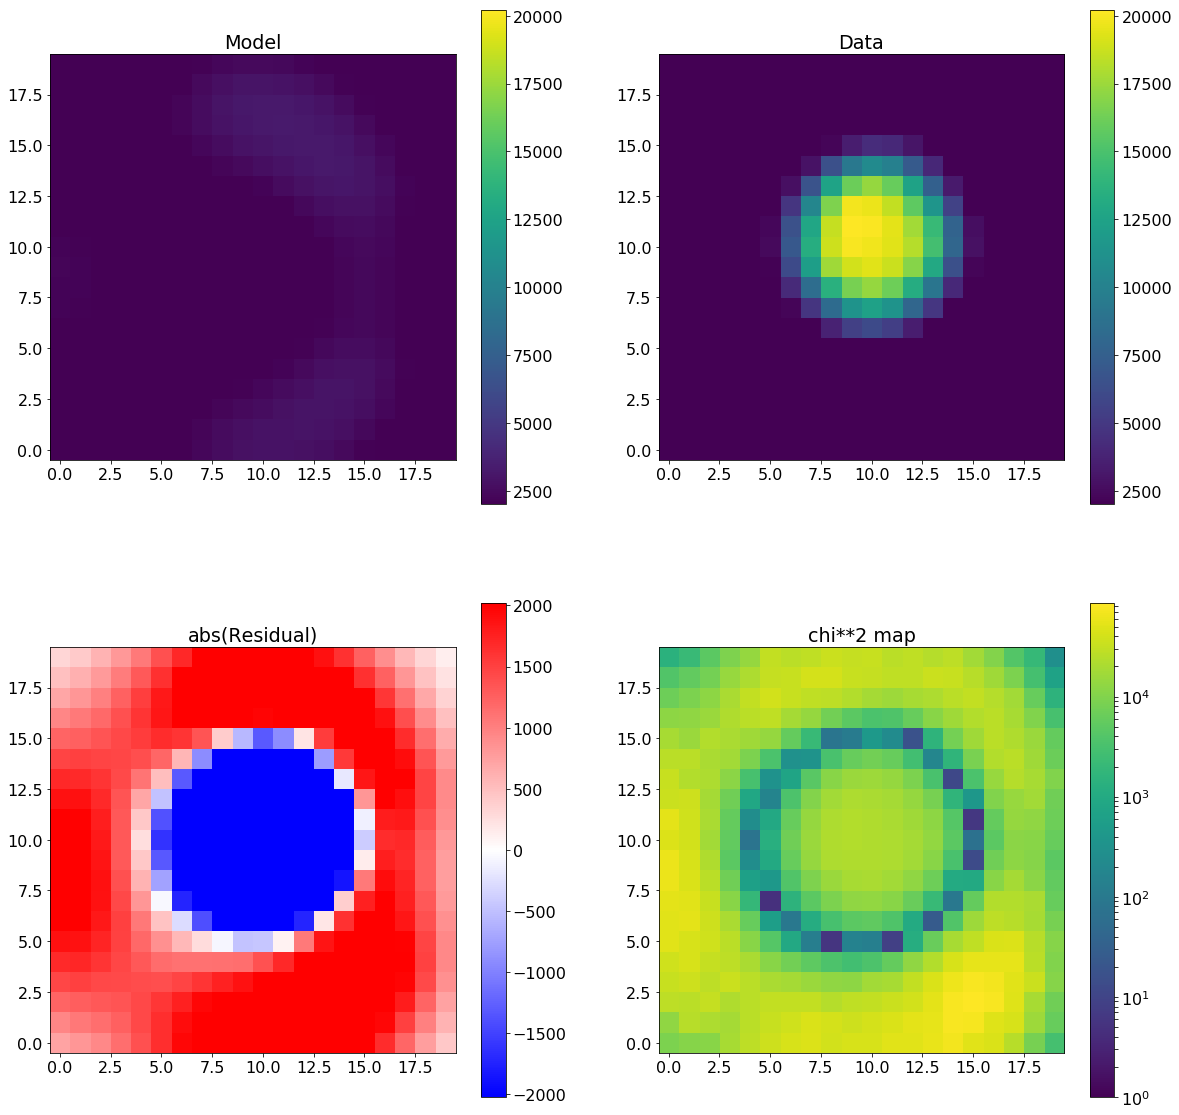

In [1919]:
plt.figure(figsize=(20,20))
plt.subplot(221)
plt.imshow(res_iapetus[10:30,10:30],origin='lower',vmin=np.max(np.abs(sci_image))/10,vmax=np.max(np.abs(sci_image)))
plt.colorbar()
plt.title('Model')
plt.grid(False)
plt.subplot(222)
plt.imshow(sci_image[10:30,10:30],origin='lower',vmin=np.max(np.abs(sci_image))/10,vmax=np.max(np.abs(sci_image)))
plt.colorbar()
plt.title('Data')
plt.grid(False)
plt.subplot(223)
plt.imshow(res_iapetus[10:30,10:30]-sci_image[10:30,10:30],origin='lower',cmap='bwr',vmin=-np.max(np.abs(sci_image))/10,vmax=np.max(np.abs(sci_image))/10)
plt.colorbar()
plt.title('abs(Residual)')
plt.grid(False)
plt.subplot(224)
plt.imshow((res_iapetus[10:30,10:30]-sci_image[10:30,10:30])**2/((1)*var_image[10:30,10:30]),origin='lower',vmin=1,norm=LogNorm())
plt.colorbar()
plt.title('chi**2 map')
print(np.sum((res_iapetus-sci_image)**2/((var_image.shape[0]*var_image.shape[1])*var_image)))
np.sum(np.abs((res_iapetus-sci_image)))/np.sum((res_iapetus))

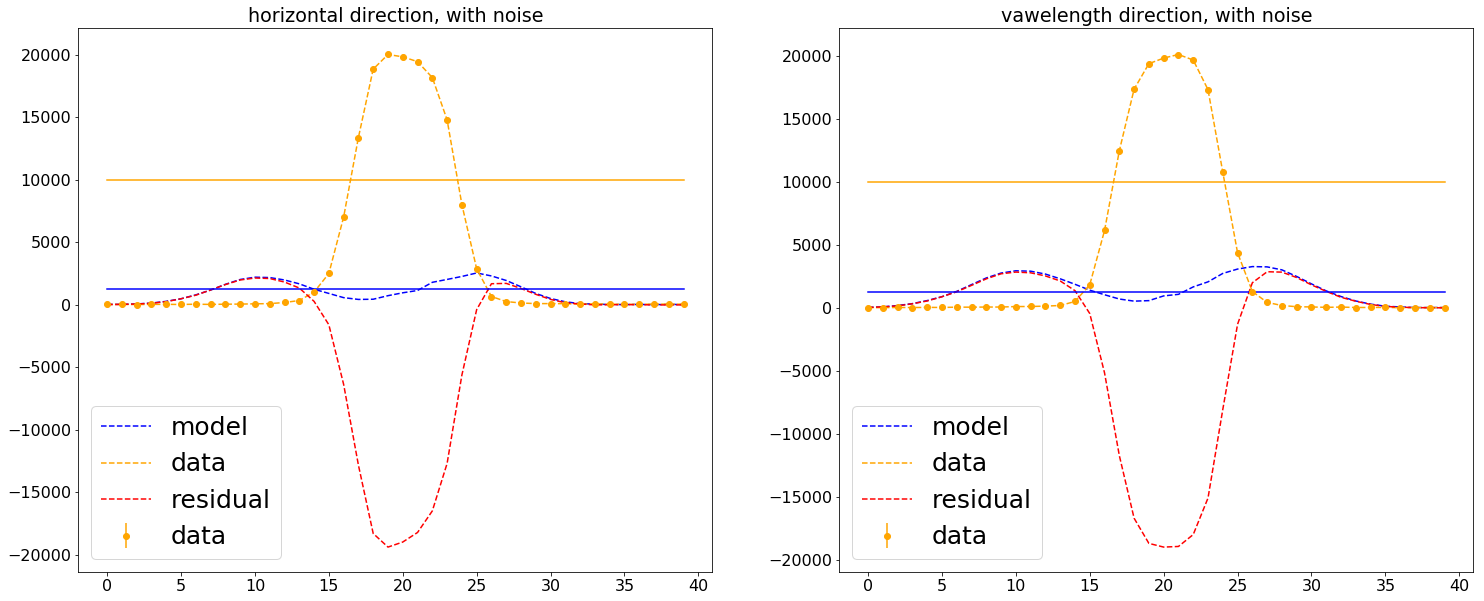

In [1920]:
plt.figure(figsize=(25,10))

plt.subplot(121)
plt.title('horizontal direction, with noise')
plt.plot(np.array(range(40)),res_iapetus[20]+artifical_noise[20],'blue',linestyle='--',label='model')
plt.plot(np.array(range(40)),sci_image[20],'orange',linestyle='--',label='data')
plt.plot(np.array(range(40)),res_iapetus[20]-sci_image[20],'red',linestyle='--',label='residual')
plt.errorbar(np.array(range(40)),sci_image[20],yerr=1*np.sqrt(var_image[20]),color='orange',label='data',fmt='o')
plt.plot(np.array(range(40)),np.ones(40)*np.max(sci_image[20]*(1/2)),'-',color='orange')
plt.plot(np.array(range(40)),np.ones(40)*np.max(res_iapetus[20]*(1/2)),'-',color='blue')
plt.legend(fontsize=25)

plt.subplot(122)
plt.title('vawelength direction, with noise')
plt.plot(np.array(range(40)),res_iapetus[:,20]+artifical_noise[:,20],'blue',linestyle='--',label='model')
plt.plot(np.array(range(40)),sci_image[:,20],'orange',linestyle='--',label='data')
plt.plot(np.array(range(40)),res_iapetus[:,20]-sci_image[:,20],'red',linestyle='--',label='residual')
plt.errorbar(np.array(range(40)),sci_image[:,20],yerr=1*np.sqrt(var_image[:,20]),color='orange',label='data',fmt='o')

plt.plot(np.array(range(40)),np.ones(40)*np.max(sci_image[20]*(1/2)),'-',color='orange')
plt.plot(np.array(range(40)),np.ones(40)*np.max(res_iapetus[20]*(1/2)),'-',color='blue')
plt.legend(fontsize=25)

# Exposure France

### initial playing

In [168]:
from astropy.io import *

res=[]
for i in range(8546,8635+1):
    hdul = fits.open('/Users/nevencaplar/Documents/PFS/2017-12-15/v000'+str(i)+'/PFLAr1.fits')
    res.append([i,hdul[0].header['W_FCA_FOCUS'],hdul[0].header['EXPTIME']])

    
res=np.array(res)
res_exposure_times=res

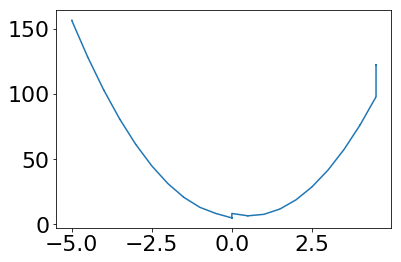

In [169]:
plt.plot(res[:,1],res[:,2])

In [112]:
np.sum(res[:,1])

3517.7310000000002

In [131]:
from astropy.io import *

res=[]
for i in range(8637,8708+1):
    hdul = fits.open('/Users/nevencaplar/Documents/PFS/2017-12-15-Rerun/v000'+str(i)+'/PFLAr1.fits')
    res.append([hdul[0].header['W_FCA_FOCUS'],hdul[0].header['EXPTIME']])

    
res=np.array(res)

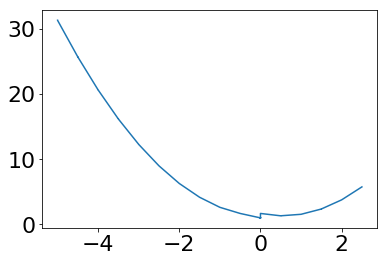

In [132]:
plt.plot(res[:,0],res[:,1])

In [116]:
np.sum(res[:,1])

423.36200000000002

## which stop is the brightest = 25 in HgAr

In [262]:
# which one is the brightest
obs=8600
res=[]
for image_index in [5,15,25,35,45,55,65,75,85,95]:
    sci_image=np.load("/Users/nevencaplar/Documents/PFS/TigerAnalysis/CutsForTigerAug15/sci"+str(obs)+str(image_index)+'Stacked_Cleaned_Dithered.npy')
    res.append([image_index,np.sum(sci_image)])
    
res=np.array(res)

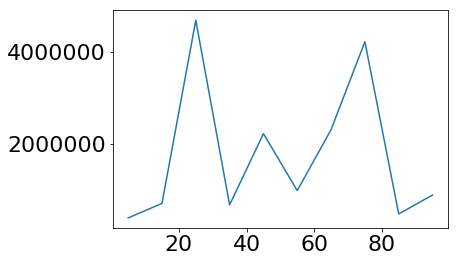

In [263]:
plt.plot(res[:,0],res[:,1])

In [129]:
# which one is the brightest
obs=8600
res=[]
for image_index in [50,51,52,53,54,55,55,57,58,59]:
    sci_image=np.load("/Users/nevencaplar/Documents/PFS/TigerAnalysis/CutsForTigerAug15/sci"+str(obs)+str(image_index)+'Stacked_Cleaned_Dithered.npy')
    res.append([image_index,np.sum(sci_image)])
    
res=np.array(res)

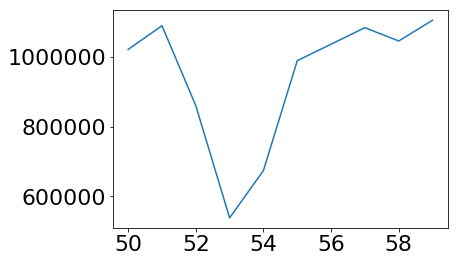

In [130]:
plt.plot(res[:,0],res[:,1])

In [264]:
res

array([[       5.        ,   395108.30400729],
       [      15.        ,   710148.25133705],
       [      25.        ,  4683875.14539063],
       [      35.        ,   677371.21305475],
       [      45.        ,  2223239.54220557],
       [      55.        ,   989056.95663559],
       [      65.        ,  2309431.59889746],
       [      75.        ,  4217440.32708585],
       [      85.        ,   480912.7847656 ],
       [      95.        ,   891316.35342577]])

## How long exposures, based on HgAr spot 25

In [1467]:
#take images without stacking!!!!
res=[]
for obs in range(8549,8633,3):
    sci_image=np.load('/Users/nevencaplar/Documents/PFS/2017-12-15/Stamps/sci'+str(obs)+'25.npy')
    hdul = fits.open('/Users/nevencaplar/Documents/PFS/2017-12-15/v000'+str(obs)+'/PFLAr1.fits')
    res.append([obs,hdul[0].header['W_FCA_FOCUS'],hdul[0].header['EXPTIME'],np.max(sci_image)])
    
res=np.array(res)
res_flux=res

In [1468]:
res_flux

array([[  8549.        ,     -4.50003   ,    128.459     ,  17383.35742188],
       [  8552.        ,     -4.00001   ,    103.177     ,  12640.74902344],
       [  8555.        ,     -3.50001   ,     80.828     ,  13089.54785156],
       [  8558.        ,     -3.        ,     61.426     ,  12503.11132812],
       [  8561.        ,     -2.5       ,     44.952     ,  13214.87792969],
       [  8564.        ,     -2.        ,     31.423     ,  13570.40722656],
       [  8567.        ,     -1.50001   ,     20.817     ,  14268.42578125],
       [  8570.        ,     -0.99999   ,     13.147     ,  16692.67578125],
       [  8573.        ,     -0.50001   ,      8.42      ,  26595.54882812],
       [  8576.        ,      0.        ,      5.013     ,  31475.79296875],
       [  8579.        ,      0.00001   ,      5.013     ,  31973.62890625],
       [  8582.        ,      0.        ,      5.013     ,  31429.88671875],
       [  8585.        ,     -0.00001   ,      5.013     ,  31366.59765625],

In [1469]:
# total time 
np.sum(res_flux[:,2]*3)/3600

0.7444774999999999

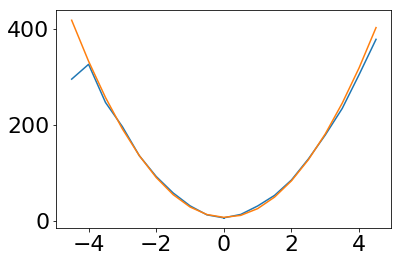

In [1476]:
p4=np.poly1d(np.polyfit(np.round(res_flux[:,1][1:],1),(40000/res_flux[:,3][1:])*res_flux[:,2][1:],2,w=-20+np.sqrt((40000/res_flux[:,3][1:])*res_flux[:,2][1:])))

plt.plot(np.round(res_flux[:,1],1),(40000/res_flux[:,3])*res_flux[:,2])
plt.plot(np.round(res_flux[:,1],1),p4(np.round(res_flux[:,1],1)))

In [1477]:
res_HgAr_exposures=[]
for i in np.unique(np.round(res_flux[:,1][0:],1)):
    res_HgAr_exposures.append([i,p4(i)])
    
res_HgAr_exposures=np.array(res_HgAr_exposures)

In [1481]:
res_HgAr_exposures

array([[  -4.5       ,  418.38337698],
       [  -4.        ,  332.89307088],
       [  -3.5       ,  257.36018717],
       [  -3.        ,  191.78472584],
       [  -2.5       ,  136.1666869 ],
       [  -2.        ,   90.50607034],
       [  -1.5       ,   54.80287617],
       [  -1.        ,   29.05710438],
       [  -0.5       ,   13.26875498],
       [   0.        ,    7.43782797],
       [   0.5       ,   11.56432334],
       [   1.        ,   25.6482411 ],
       [   1.5       ,   49.68958124],
       [   2.        ,   83.68834377],
       [   2.5       ,  127.64452868],
       [   3.        ,  181.55813598],
       [   3.5       ,  245.42916567],
       [   4.        ,  319.25761774],
       [   4.5       ,  403.0434922 ]])

In [1482]:
res=[]
for i in range(10):
    res.append([(np.abs(res_HgAr_exposures[:,0][0+i])+res_HgAr_exposures[:,0][-1-i])/2,np.round((res_HgAr_exposures[:,1][0+i]+res_HgAr_exposures[:,1][-1-i])/2)])
    
res_HgAr_exposures_round=np.array(res)

In [1483]:
res_HgAr_exposures_round

array([[   4.5,  411. ],
       [   4. ,  326. ],
       [   3.5,  251. ],
       [   3. ,  187. ],
       [   2.5,  132. ],
       [   2. ,   87. ],
       [   1.5,   52. ],
       [   1. ,   27. ],
       [   0.5,   12. ],
       [   0. ,    7. ]])

## SNR analysis 

In [1484]:
image_index=25  
obs=8600
sci_image=np.load("/Users/nevencaplar/Documents/PFS/TigerAnalysis/CutsForTigerAug15/sci"+str(obs)+str(image_index)+'Stacked_Cleaned_Dithered.npy')
var_image=np.load("/Users/nevencaplar/Documents/PFS/TigerAnalysis/CutsForTigerAug15/var"+str(obs)+str(image_index)+'Stacked_Dithered.npy')

def create_artifical_var_image(sci_image,Exposure_time_single,Number_of_Exposures,Exposure_time_single_original):
    '''
    sci_image: data which you have now
    Exposure_time_single: how long single exposure
    Number_of_Exposures: how many do you want to make
    Exposure_time_single_original: how long single exposure in the original data (HgAr: 5, Neon: 1)    
    '''
    assert sci_image.shape[0]==40
    sci_image_template=np.load("/Users/nevencaplar/Documents/PFS/TigerAnalysis/CutsForTigerAug15/sci"+str(8600)+str(25)+'Stacked_Cleaned_Dithered.npy')
    sci_image_template98Percentile=np.percentile(sci_image_template,99)
    sci_image_98Percentile=np.percentile(sci_image,99)
    first_var_image=((sci_image_98Percentile/sci_image_template98Percentile)*sci_image_template*0.8)*Exposure_time_single/Exposure_time_single_original+Number_of_Exposures*20
    first_var_image[first_var_image<Number_of_Exposures*20]=Number_of_Exposures*20
    return first_var_image

def create_artifical_sci_image(sci_image,Exposure_time_single,Number_of_Exposures,Exposure_time_single_original,Number_of_Exposures_original):
    '''
    sci_image: data which you have now
    Exposure_time_single: how long single exposure
    Number_of_Exposures: how many do you want to make
    Exposure_time_single_original: how long single exposure in the original data (HgAr: 5, Neon: 1)
    Number_of_Exposures_original: how man exposures in the original data (HgAr: 3, Neon: 3)
    
    
    '''
    sci_image_template=np.load("/Users/nevencaplar/Documents/PFS/TigerAnalysis/CutsForTigerAug15/sci"+str(8600)+str(25)+'Stacked_Cleaned_Dithered.npy')
    sci_image_template98Percentile=np.percentile(sci_image_template,99)
    sci_image_98Percentile=np.percentile(sci_image,99)
    return ((sci_image_98Percentile/sci_image_template98Percentile)*sci_image_template*1)*Exposure_time_single/Exposure_time_single_original*Number_of_Exposures/Number_of_Exposures_original

### proportionality between science and var image

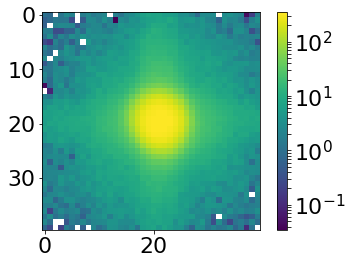

In [1485]:
plt.imshow(sci_image/np.sqrt(var_image),norm=LogNorm())
plt.colorbar()

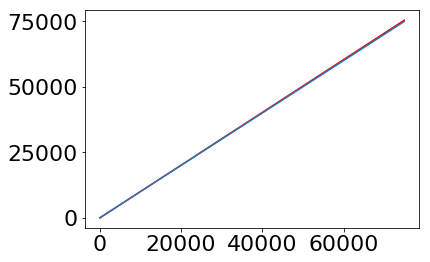

In [1486]:
# not linear, but 0.8 proportionality between sci and var images
plt.plot(np.sort(np.ravel(var_image)),0.80*np.sort(np.ravel(sci_image)),color='red')
plt.plot(np.sort(np.ravel(var_image)),np.sort(np.ravel(var_image)))

### SNR for best image

5.75345894382


(0, 2)

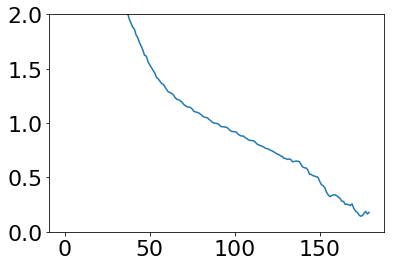

In [1487]:
plt.plot(np.log10(create_res_data(sci_image/np.sqrt(var_image),None,1)))
print(create_res_data(sci_image/np.sqrt(var_image),None,1)[120])
plt.ylim(0,2)

### SNR for simulated best image

In [1277]:
test_sci_image=create_artifical_sci_image(sci_image,5,3,5,3)
test_var_image=create_artifical_var_image(sci_image,5,3,5)

0.564890720975


(0, 2)

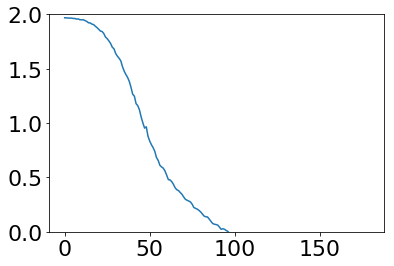

In [1278]:
plt.plot(np.log10(create_res_data(test_sci_image/np.sqrt(test_var_image),None,1)))
print(create_res_data(test_sci_image/np.sqrt(test_var_image),None,1)[120])
plt.ylim(0,2)

### additional test 

In [1279]:
image_index=41 
obs=8600
sci_image=np.load("/Users/nevencaplar/Documents/PFS/TigerAnalysis/CutsForTigerAug15/sci"+str(obs)+str(image_index)+'Stacked_Cleaned_Dithered.npy')
var_image=np.load("/Users/nevencaplar/Documents/PFS/TigerAnalysis/CutsForTigerAug15/var"+str(obs)+str(image_index)+'Stacked_Dithered.npy')

3.77038031085


(0, 2)

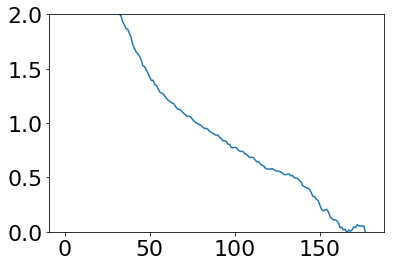

In [1280]:
plt.plot(np.log10(create_res_data(sci_image/np.sqrt(var_image),None,1)))
print(create_res_data(sci_image/np.sqrt(var_image),None,1)[120])
plt.ylim(0,2)

In [1281]:
test_sci_image=create_artifical_sci_image(sci_image,5,3,5,3)
test_var_image=create_artifical_var_image(sci_image,5,3,5)

In [1282]:
test_artifical_noise=np.zeros((40,40))
for i in range(40):
    for j in range(40):
        test_artifical_noise[i,j]=np.random.normal(0,np.sqrt(test_var_image[i,j]))

3.18404151086


(0, 3)

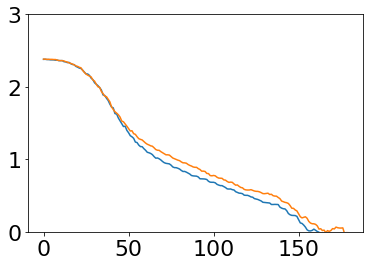

In [1283]:
plt.plot(np.log10(create_res_data((test_sci_image)/np.sqrt(test_var_image),None,1)))
plt.plot(np.log10(create_res_data(sci_image/np.sqrt(var_image),None,1)))
print(create_res_data(test_sci_image/np.sqrt(test_var_image),None,1)[120])
plt.ylim(0,3)

In [960]:
np.max(sci_image)

48093.790832519531

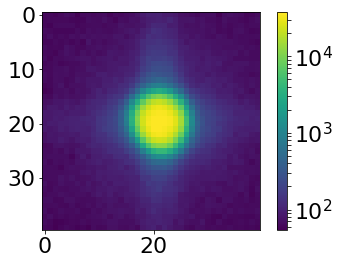

In [961]:
plt.imshow(test_var_image,norm=LogNorm())
plt.colorbar()

(0, 500)

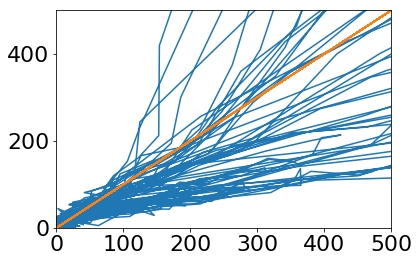

In [962]:
plt.plot(np.ravel(sci_image),np.ravel(test_sci_image))
plt.plot(np.ravel(test_sci_image),np.ravel(test_sci_image))
plt.xlim(0,500)
plt.ylim(0,500)

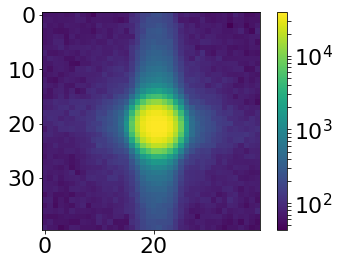

In [963]:
plt.imshow(var_image,norm=LogNorm())
plt.colorbar()

### Using relation

In [1488]:
image_index=5  
obs=8600
sci_image=np.load("/Users/nevencaplar/Documents/PFS/TigerAnalysis/CutsForTigerAug15/sci"+str(obs)+str(image_index)+'Stacked_Cleaned_Dithered.npy')
var_image=np.load("/Users/nevencaplar/Documents/PFS/TigerAnalysis/CutsForTigerAug15/var"+str(obs)+str(image_index)+'Stacked_Dithered.npy')

test_sci_image=create_artifical_sci_image(sci_image,9,30,5,3)
test_var_image=create_artifical_var_image(sci_image,9,30,5)
print(create_res_data(test_sci_image/np.sqrt(test_var_image),None,1)[120])

3.30909436307


### Summation 

In [1489]:
res_HgAr_exposures_round[:,1]=res_HgAr_exposures_round[:,1]
res_HgAr_exposures_round[:,1]

array([ 411.,  326.,  251.,  187.,  132.,   87.,   52.,   27.,   12.,    7.])

In [1490]:
res_HgAr_exposures_round_with_overhead=np.copy(res_HgAr_exposures_round)
res_HgAr_exposures_round_with_overhead[:,1]=res_HgAr_exposures_round_with_overhead[:,1]+40

In [1491]:
res_HgAr_exposures_round

array([[   4.5,  411. ],
       [   4. ,  326. ],
       [   3.5,  251. ],
       [   3. ,  187. ],
       [   2.5,  132. ],
       [   2. ,   87. ],
       [   1.5,   52. ],
       [   1. ,   27. ],
       [   0.5,   12. ],
       [   0. ,    7. ]])

In [1492]:
Dithered_HgAr=(res_HgAr_exposures_round[:,1][-1]*(30*4)+2*res_HgAr_exposures_round[:,1][-2]*(6*4)+2*res_HgAr_exposures_round[:,1][-3]*(6*4))
Dithered_HgAr/3600

0.7533333333333333

In [1493]:
Dithered_HgAr_with_overhead=(res_HgAr_exposures_round_with_overhead[:,1][-1]*(30*4)+2*res_HgAr_exposures_round_with_overhead[:,1][-2]*(6*4)+2*res_HgAr_exposures_round_with_overhead[:,1][-3]*(6*4))
Dithered_HgAr_with_overhead/3600

3.1533333333333333

In [1494]:
NoDithered_HgAr=(res_HgAr_exposures_round[:,1][-4]*3*2+res_HgAr_exposures_round[:,1][-5]*3*2+
            res_HgAr_exposures_round[:,1][-6]*3*2+res_HgAr_exposures_round[:,1][-7]*3*2+res_HgAr_exposures_round[:,1][-8]*3*2+res_HgAr_exposures_round[:,1][-9]*3*2)
NoDithered_HgAr/3600

1.7250000000000001

In [1495]:
NoDithered_HgAr_with_overhead=(res_HgAr_exposures_round_with_overhead[:,1][-4]*3*2+res_HgAr_exposures_round_with_overhead[:,1][-5]*3*2+
            res_HgAr_exposures_round_with_overhead[:,1][-6]*3*2+res_HgAr_exposures_round_with_overhead[:,1][-7]*3*2+res_HgAr_exposures_round_with_overhead[:,1][-8]*3*2+res_HgAr_exposures_round_with_overhead[:,1][-9]*3*2)
NoDithered_HgAr_with_overhead/3600

2.125

In [1496]:
Dithered=(res_HgAr_exposures_round[:,1][-1]*(30*4)+2*res_HgAr_exposures_round[:,1][-2]*(30*4)+2*res_HgAr_exposures_round[:,1][-2]*(30*4))
Dithered/3600

1.8333333333333333

In [1497]:
Dithered_with_overhead=(res_HgAr_exposures_round_with_overhead[:,1][-1]*(30*4)+2*res_HgAr_exposures_round_with_overhead[:,1][-2]*(30*4)+2*res_HgAr_exposures_round_with_overhead[:,1][-2]*(30*4))
Dithered_with_overhead/3600

8.5

In [1498]:
(Dithered_HgAr+NoDithered_HgAr)/3600

2.4783333333333335

In [1499]:
(Dithered_HgAr_with_overhead+NoDithered_HgAr_with_overhead)/3600

5.2783333333333333

In [1500]:
Dithered_HgAr

2712.0

## Neon

### initial investigation

In [1100]:
# which object is the brightest
# how many images are in this stack - 3 (Stacked_Dithered=12, Stacked =3)
obs=8690
res=[]
for image_index in np.array([5,15,25,35,45,55,65,75,85,95]):
    sci_image=np.load("/Users/nevencaplar/Documents/PFS/2017-12-15-Rerun/StampsNeon/sci"+str(obs)+str(image_index)+'Stacked.npy')
    res.append([image_index,np.sum(sci_image),np.max(sci_image)])
    
res=np.array(res)


In [1101]:
res

array([[      5.        ,    4450.4375    ,     324.22302246],
       [     15.        ,    4943.53173828,     401.55349731],
       [     25.        ,    5546.07910156,     445.65759277],
       [     35.        ,   21249.40039062,    1768.12426758],
       [     45.        ,   79241.1328125 ,    6446.16210938],
       [     55.        ,  143943.296875  ,   10709.30078125],
       [     65.        ,  674670.75      ,   55138.26171875],
       [     75.        ,  252569.953125  ,   20155.97851562],
       [     85.        ,  174543.75      ,   14313.18457031],
       [     95.        ,  124044.328125  ,   10409.8046875 ]])

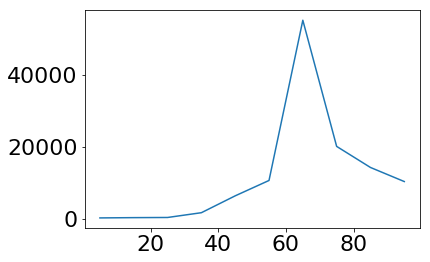

In [1102]:
plt.plot(res[:,0],res[:,2])

In [1103]:
res

array([[      5.        ,    4450.4375    ,     324.22302246],
       [     15.        ,    4943.53173828,     401.55349731],
       [     25.        ,    5546.07910156,     445.65759277],
       [     35.        ,   21249.40039062,    1768.12426758],
       [     45.        ,   79241.1328125 ,    6446.16210938],
       [     55.        ,  143943.296875  ,   10709.30078125],
       [     65.        ,  674670.75      ,   55138.26171875],
       [     75.        ,  252569.953125  ,   20155.97851562],
       [     85.        ,  174543.75      ,   14313.18457031],
       [     95.        ,  124044.328125  ,   10409.8046875 ]])

In [1104]:
# which object is the brightest
# how many images are in this stack - 12 (Stacked_Dithered=12, Stacked =3)
obs=8690
res=[]
for image_index in np.array([5,15,25,35,45,55,65,75,85,95]):
    sci_image=np.load("/Users/nevencaplar/Documents/PFS/2017-12-15-Rerun/StampsNeon/sci"+str(obs)+str(image_index)+'Stacked_Dithered.npy')
    res.append([image_index,np.sum(sci_image),np.max(sci_image)])
    
res=np.array(res)



In [1105]:
#brightest spot
run_full=np.array([8576,8579,8582,8585,8588,8591,8594,8597,8600,8603])+90

res=[]
for obs in run_full:
    sci_image=np.load('/Users/nevencaplar/Documents/PFS/2017-12-15-Rerun/StampsNeon/sci'+str(obs)+'55Stacked.npy')
    hdul = fits.open('/Users/nevencaplar/Documents/PFS/2017-12-15-Rerun/v000'+str(obs)+'/PFLAr1.fits')
    res.append([obs,hdul[0].header['W_FCA_FOCUS'],hdul[0].header['EXPTIME'],np.max(sci_image)])
    
res=np.array(res)
res_flux=res

In [1106]:
res_flux

array([[  8666.        ,      0.        ,      1.006     ,  10703.41601562],
       [  8669.        ,      0.00001   ,      1.007     ,  10808.49609375],
       [  8672.        ,      0.        ,      1.006     ,  10795.69042969],
       [  8675.        ,     -0.        ,      1.006     ,  10802.90820312],
       [  8678.        ,     -0.00001   ,      1.006     ,  11188.078125  ],
       [  8681.        ,      0.00001   ,      1.011     ,  10795.5       ],
       [  8684.        ,      0.00001   ,      1.006     ,  10771.83007812],
       [  8687.        ,     -0.        ,      1.006     ,  10781.20898438],
       [  8690.        ,     -0.00001   ,      1.006     ,  10709.30078125],
       [  8693.        ,      0.00001   ,      1.686     ,  18292.14453125]])

In [1107]:
#2nd brightest spot
run_full=np.array([8576,8579,8582,8585,8588,8591,8594,8597,8600,8603])+90

res=[]
for obs in run_full:
    sci_image=np.load('/Users/nevencaplar/Documents/PFS/2017-12-15-Rerun/StampsNeon/sci'+str(obs)+'75Stacked.npy')
    hdul = fits.open('/Users/nevencaplar/Documents/PFS/2017-12-15-Rerun/v000'+str(obs)+'/PFLAr1.fits')
    res.append([obs,hdul[0].header['W_FCA_FOCUS'],hdul[0].header['EXPTIME'],np.max(sci_image)])
    
res=np.array(res)
res_flux=res


In [1108]:
res_flux

array([[  8666.        ,      0.        ,      1.006     ,  20003.4609375 ],
       [  8669.        ,      0.00001   ,      1.007     ,  20660.18359375],
       [  8672.        ,      0.        ,      1.006     ,  19973.91992188],
       [  8675.        ,     -0.        ,      1.006     ,  20065.66015625],
       [  8678.        ,     -0.00001   ,      1.006     ,  20696.84375   ],
       [  8681.        ,      0.00001   ,      1.011     ,  20221.0859375 ],
       [  8684.        ,      0.00001   ,      1.006     ,  20042.16796875],
       [  8687.        ,     -0.        ,      1.006     ,  20517.53125   ],
       [  8690.        ,     -0.00001   ,      1.006     ,  20155.97851562],
       [  8693.        ,      0.00001   ,      1.686     ,  34053.453125  ]])

In [1109]:
# checking

single_number_for_single_pos_full_pd_Neon= pd.read_pickle("/Users/nevencaplar/Documents/PFS/2017-12-15/single_number_for_single_pos_full_pd_Neon.pkl")

run=8690
data=fits.open('/Users/nevencaplar/Documents/PFS/2017-12-15-Rerun/v000'+str(run)+'/PFLAr1.fits')
scidata8603=np.flipud(data[1].data)
vardata8603=np.flipud(data[3].data)

run2=run+1
data=fits.open('/Users/nevencaplar/Documents/PFS/2017-12-15-Rerun/v000'+str(run2)+'/PFLAr1.fits')
scidata8604=np.flipud(data[1].data)
vardata8604=np.flipud(data[3].data)

run3=run+2
data=fits.open('/Users/nevencaplar/Documents/PFS/2017-12-15-Rerun/v000'+str(run3)+'/PFLAr1.fits')
scidata8605=np.flipud(data[1].data)
vardata8605=np.flipud(data[3].data)

i=65
dx=int(single_number_for_single_pos_full_pd_Neon.iloc[i]['xc'])
dy=int(single_number_for_single_pos_full_pd_Neon.iloc[i]['yc'])

scidata_cut_single=scidata8603[4176-(dy+10):4176-(dy-10),dx-10:dx+10]
vardata_cut_single=vardata8603[4176-(dy+10):4176-(dy-10),dx-10:dx+10]

scidata_cut=scidata8603[4176-(dy+10):4176-(dy-10),dx-10:dx+10]+scidata8604[4176-(dy+10):4176-(dy-10),dx-10:dx+10]+scidata8605[4176-(dy+10):4176-(dy-10),dx-10:dx+10]
vardata_cut=vardata8603[4176-(dy+10):4176-(dy-10),dx-10:dx+10]+vardata8604[4176-(dy+10):4176-(dy-10),dx-10:dx+10]+vardata8605[4176-(dy+10):4176-(dy-10),dx-10:dx+10]

In [1110]:
single_number_for_single_pos_full_pd_Neon.iloc[i]

fiber       5.0
spot        6.0
xc       2089.0
yc       1143.0
Name: 65.0, dtype: float64

18308.416

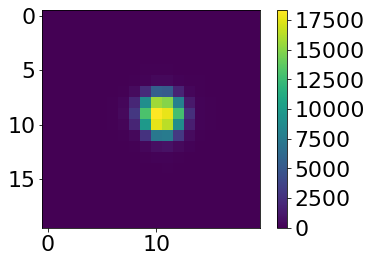

In [1114]:
plt.imshow(scidata_cut_single)
plt.colorbar()
np.max(scidata_cut_single)

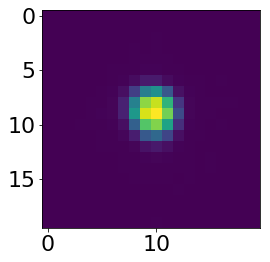

In [1099]:
plt.imshow(np.load('/Users/nevencaplar/Documents/PFS/2017-12-15-Rerun/StampsNeon/sci'+str(8690)+str(i)+'Stacked.npy'))

### Using my super ultra code 

#### testing

-0.134376319488


(0, 2)

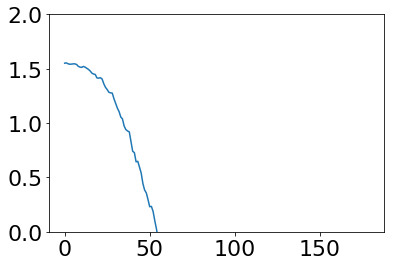

In [1233]:
image_index=5
obs=8690
sci_image=np.load('/Users/nevencaplar/Documents/PFS/2017-12-15-Rerun/StampsNeon/sci'+str(obs)+str(image_index)+'Stacked_Dithered.npy')
var_image=np.load("/Users/nevencaplar/Documents/PFS/2017-12-15-Rerun/StampsNeon/var"+str(obs)+str(image_index)+'Stacked_Dithered.npy')

plt.plot(np.log10(create_res_data(sci_image/np.sqrt(var_image),None,1)))
print(create_res_data(sci_image/np.sqrt(var_image),None,1)[120])
plt.ylim(0,2)

In [1234]:
test_sci_image=create_artifical_sci_image(sci_image,500,3,1,12)
test_var_image=create_artifical_var_image(sci_image,500,3,1)

# this is just to check that one would not notice struts in the real data
artifical_noise_data=np.zeros((test_var_image.shape[0],test_var_image.shape[1]))
for i in range(len(artifical_noise_data)):
    for j in range(len(artifical_noise_data)):
        artifical_noise_data[i][j]=np.random.normal(0,np.sqrt(test_var_image[i][j]))

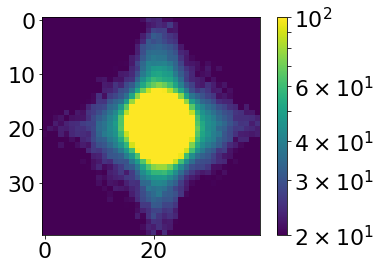

In [1242]:
plt.imshow(np.sqrt(test_var_image),norm=LogNorm(),vmax=100,vmin=20)
plt.colorbar()

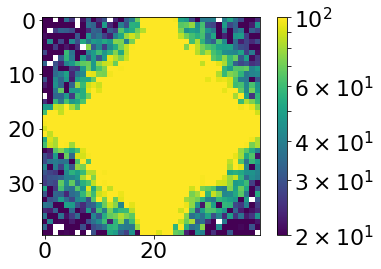

In [1243]:
plt.imshow(test_sci_image,norm=LogNorm(),vmax=100,vmin=20)
plt.colorbar()

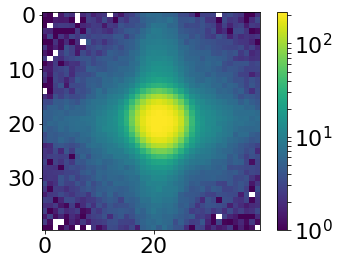

In [1244]:
plt.imshow(test_sci_image/np.sqrt(test_var_image),norm=LogNorm(),vmin=1)
plt.colorbar()

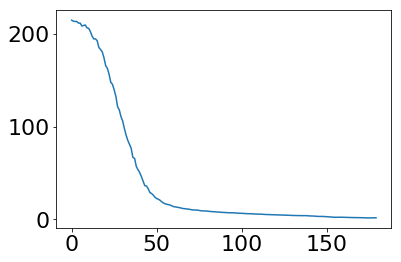

In [1245]:
plt.plot(create_res_data(test_sci_image/np.sqrt(test_var_image),None,1))

4.79893813582


(0, 10)

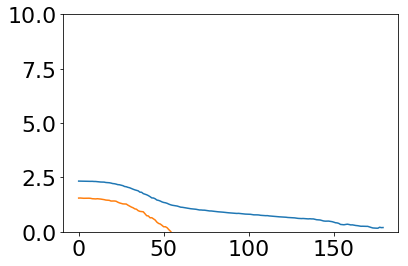

In [1246]:
plt.plot(np.log10(create_res_data((test_sci_image)/np.sqrt(test_var_image),None,1)))
plt.plot(np.log10(create_res_data(sci_image/np.sqrt(var_image),None,1)))
print(create_res_data(test_sci_image/np.sqrt(test_var_image),None,1)[120])
plt.ylim(0,10)

## checking how bad the leaking it in the wavelength direction

### Summation of Neon and everything

In [1501]:
res_HgAr_exposures_round

array([[   4.5,  411. ],
       [   4. ,  326. ],
       [   3.5,  251. ],
       [   3. ,  187. ],
       [   2.5,  132. ],
       [   2. ,   87. ],
       [   1.5,   52. ],
       [   1. ,   27. ],
       [   0.5,   12. ],
       [   0. ,    7. ]])

In [1505]:
res_Neon_exposures=np.copy(res_HgAr_exposures_round)
res_Neon_exposures[:,1]=np.round(res_Neon_exposures[:,1]/(7/3),1)

In [1506]:
res_Neon_exposures

array([[   4.5,  176.1],
       [   4. ,  139.7],
       [   3.5,  107.6],
       [   3. ,   80.1],
       [   2.5,   56.6],
       [   2. ,   37.3],
       [   1.5,   22.3],
       [   1. ,   11.6],
       [   0.5,    5.1],
       [   0. ,    3. ]])

In [1507]:
res_Neon_exposures_with_overhead=np.copy(res_Neon_exposures)
res_Neon_exposures_with_overhead[:,1]=res_Neon_exposures_with_overhead[:,1]+40

In [1508]:
res_Neon_exposures_with_overhead

array([[   4.5,  216.1],
       [   4. ,  179.7],
       [   3.5,  147.6],
       [   3. ,  120.1],
       [   2.5,   96.6],
       [   2. ,   77.3],
       [   1.5,   62.3],
       [   1. ,   51.6],
       [   0.5,   45.1],
       [   0. ,   43. ]])

In [1509]:
res_Neon_exposures[:,1][-3]

11.6

In [1510]:
Dithered_Neon=(res_Neon_exposures[:,1][-1]*(30*4)+res_Neon_exposures[:,1][-2]*(2*6*4)+res_Neon_exposures[:,1][-3]*(2*6*4))
print(Dithered_Neon)
print(Dithered_Neon/3600)

1161.6
0.322666666667


In [1511]:
Dithered_Neon_with_overhead=(res_Neon_exposures_with_overhead[:,1][-1]*(30*4)+res_Neon_exposures_with_overhead[:,1][-2]*(2*6*4)+res_Neon_exposures_with_overhead[:,1][-3]*(2*6*4))
print(Dithered_Neon_with_overhead)
print(Dithered_Neon_with_overhead/3600)

9801.6
2.72266666667


In [1512]:
NoDithered_Neon=(res_Neon_exposures[:,1][-4]*6+res_Neon_exposures[:,1][-5]*6)*2
print(NoDithered_Neon)
print(NoDithered_Neon/3600)


715.2
0.198666666667


In [1513]:
NoDithered_Neon_with_overhead=(res_Neon_exposures_with_overhead[:,1][-4]*6+res_Neon_exposures_with_overhead[:,1][-5]*6)*2
NoDithered_Neon_with_overhead/3600
print(NoDithered_Neon_with_overhead)
print(NoDithered_Neon_with_overhead/3600)

1675.2
0.465333333333


In [1514]:
NoDithered_Neon_Custom=(500*3+100*3)
NoDithered_Neon_Custom/3600

0.5

In [1515]:
NoDithered_Neon_Custom_with_overhead=((500+40)*3+(100+40)*3)
NoDithered_Neon_Custom_with_overhead/3600

0.5666666666666667

In [1516]:
print((NoDithered_HgAr+Dithered_HgAr)/3600)
print((NoDithered_Neon+Dithered_Neon)/3600)

2.47833333333
0.521333333333


In [1517]:
(Dithered_HgAr+NoDithered_HgAr)/3600+(Dithered_Neon+NoDithered_Neon)/3600

2.9996666666666667

In [1531]:
print((Dithered_HgAr_with_overhead+120)/3600)
print((NoDithered_HgAr_with_overhead)/3600)
print((Dithered_Neon_with_overhead)/3600)
print((NoDithered_Neon_with_overhead)/3600)
print((NoDithered_Neon_Custom_with_overhead)/3600)

print((Dithered_HgAr_with_overhead))
print((NoDithered_HgAr_with_overhead))
print((Dithered_Neon_with_overhead))
print((NoDithered_Neon_with_overhead))
print((NoDithered_Neon_Custom_with_overhead))

(Dithered_HgAr_with_overhead+NoDithered_HgAr_with_overhead)/3600+(Dithered_Neon_with_overhead+NoDithered_Neon_with_overhead+NoDithered_Neon_Custom_with_overhead)/3600

3.18666666667
2.125
2.72266666667
0.465333333333
0.566666666667
11352.0
7650.0
9801.6
1675.2
2040


9.0329999999999995

In [1532]:
print((Dithered_HgAr)/3600)
print((NoDithered_HgAr)/3600)
print((Dithered_Neon)/3600)
print((NoDithered_Neon)/3600)
print((NoDithered_Neon_Custom)/3600)


print((Dithered_HgAr))
print((NoDithered_HgAr))
print((Dithered_Neon))
print((NoDithered_Neon))
print((NoDithered_Neon_Custom))

(Dithered_HgAr+120+NoDithered_HgAr)/3600+(Dithered_Neon+NoDithered_Neon+NoDithered_Neon_Custom)/3600

0.753333333333
1.725
0.322666666667
0.198666666667
0.5
2712.0
6210.0
1161.6
715.2
1800


3.5330000000000004

In [1520]:
(Dithered_Neon_with_overhead+NoDithered_Neon_with_overhead+NoDithered_Neon_Custom_with_overhead)/3600

3.7546666666666666

In [1528]:
(Dithered_HgAr_with_overhead+120+NoDithered_HgAr_with_overhead)/3600

5.3116666666666665

In [1522]:
5.92+3.75

9.67

In [1523]:
2.72+0.46+0.57

3.75

In [1524]:
120+48+48+12+12

240

In [1306]:
240+258500

498

In [1307]:
500*40/3600

5.555555555555555

In [1364]:
120*9+48*15+48*34+6*66+6*110+6*166+6*235+6*317+6*411+6*518

14370

In [1394]:
120*3+48*5+48*11+6*22+6*37+3*100+3*500

3282

In [1366]:
14370+3258

17628

In [1367]:
17625/3600

4.895833333333333

In [1368]:
3*100+3*500

1800

In [1369]:
14370/3600

3.9916666666666667

In [1370]:
print((Dithered_Neon)/3600)
print((NoDithered_Neon)/3600)
print((NoDithered_Neon_Custom)/3600)

0.317777777778
0.220740740741
0.5


In [1371]:
0.5+0.22+0.32

1.04